In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import pickle
import itertools
import networkx as nx
import scanpy as sc
import matplotlib.pyplot as plt
import pwlf

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/Users/yijwang-admin/Documents/Research/GRN_PPI/L0GL_PPI_GRN/')

from minConf.minConf_PQN import minConF_PQN

/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from 

# Functions

In [35]:


def ShorestPath_GivenTFs(Gnx, TFlist, FilePathes):
    Ol_TF = list(set(Gnx.nodes) & set(TFlist))
    #print("Only ", len(Ol_TF), " TFs (", len(TFlist), " in total) appear in the network.")
    
    fh = open(FilePathes, 'w')
    ShortPath = list()
    NumNoPath = 0
    for i in range(len(Ol_TF)):
        for j in range(i+1, len(Ol_TF)):
            if nx.has_path(Gnx, Ol_TF[i], Ol_TF[j]):
                sp = nx.shortest_path_length(Gnx, Ol_TF[i], Ol_TF[j])
                Path = nx.shortest_path(Gnx, source=Ol_TF[i], target=Ol_TF[j])
                for n in Path:
                    fh.write("%s " % n)
                fh.write("%d\n" % sp)
                ShortPath.append(sp)
            else:
                fh.write("No path between %s and %s\n" % ( Ol_TF[i], Ol_TF[j]))
                NumNoPath = NumNoPath + 1
                #ShortPath.append(10)
    fh.close()

    return ShortPath

def Short_Path_Matrix(Gnx, TFlist, MaxLen = 6):
    NodesG = Gnx.nodes
    
    N = len(TFlist)
    Smat = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i+1, N):
            if TFlist[i] in NodesG and TFlist[j] in NodesG:
                if nx.has_path(Gnx, TFlist[i], TFlist[j]):
                    Smat[i,j] = nx.shortest_path_length(Gnx, TFlist[i], TFlist[j])
                    Smat[j,i] = Smat[i,j]
                else:
                    Smat[i,j] = MaxLen
                    Smat[j,i] = Smat[i,j]
            else:
                Smat[i,j] = MaxLen
                Smat[j,i] = Smat[i,j]
                
    return Smat


def Short_Path_DSD_Matrix(Gnx, TFlist, MaxLen = 5):
    NodesG = Gnx.nodes
    
    N = len(TFlist)
    Smat = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i+1, N):
            if TFlist[i] in NodesG and TFlist[j] in NodesG:
                Smat[i,j] = Gnx.edges[TFlist[i], TFlist[j]]['weight']
                Smat[j,i] = Smat[i,j]   
                #print(Smat[i,j])
            else:
                #print(TFlist[i], TFlist[j])
                Smat[i,j] = MaxLen
                Smat[j,i] = Smat[i,j]
                
    return Smat



In [36]:
# 

import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv
from gurobipy import Model, GRB, QuadExpr

def L0GLObj(u, X, y, pho):
    # u (feature, 1)
    # X (instance, feature)
    # y (instance, 1)
    # pho (1, 1)
    #print(pho)
    #print(u)
    n, d = X.shape
    SpDiag = spdiags(u.flatten(), 0, d, d)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.conj().T + np.eye(n))
    f = y.conj().T @ M @ y

    g = -(1/pho) * ((X.conj().T @ M @ y)**2)

    return f, g

def L0Obj(u, X, y, pho):
    # u (feature, 1)
    # X (instance, feature)
    # y (instance, 1)
    # pho (1, 1)
    #print(pho)
    n, d = X.shape
    SpDiag = spdiags(u.flatten(), 0, d, d)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.conj().T + np.eye(n))
    f = y.conj().T @ M @ y

    g = -(1/pho) * ((X.conj().T @ M @ y)**2)

    return f, g

def L0GL_PPI_Obj(u, X, y, S, pho, lam):
    # u (feature, 1)
    # X (instance, feature)
    # y (instance, 1)
    # pho (1, 1)
    #print(pho)
    #print(u)
    n, d = X.shape
    SpDiag = spdiags(u.flatten(), 0, d, d)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.T + np.eye(n))
    f = y.T @ M @ y + lam * u.T @ S @ u

    g = -(1/pho) * ((X.T @ M @ y)**2) + 2 * lam * S @ u

    return f, g


def ProjCSimplex(u, k):
    """
    Projects vector u onto the simplex defined by the sum of elements equal to k.
    """
    # u = u.flatten()
    # print(u.shape)
    n, m = u.shape
    # print(f"n: {n}, {m}")

    H = 0.5*np.eye(n)
    f = -0.5 * u
    A = np.ones((1, n))
    b = k

    lb = np.zeros((n, 1))
    ub = np.ones((n, 1))
    
    if np.sum(u) < k and np.all(np.logical_and(u >= 0, u <= 1)):
        up = u
    else:
        d = len(u)
        e = np.ones((d, 1))
        z0 = np.zeros((d, 1))
        l0 = float(0 + np.random.rand() * np.min(u))
        error = 100
        idt = 0
        while error > 1e-8:
            tmp = u - l0
            # tmp[tmp > 1] = 1
            # tmp[tmp < 0] = 0
            tmp = np.clip(tmp, 0, 1)
            error = k - np.sum(tmp)
            n = np.count_nonzero(tmp)
            if n == 0:
                l0 = float(0+np.random.rand() * np.min(u))
                error = 100
                continue
            idt += 1
            l1 = l0 - (error / n)
            tmp = u - l1
            # tmp[tmp > 1] = 1
            # tmp[tmp < 0] = 0
            tmp = np.clip(tmp, 0, 1)
            error = np.abs(k - np.sum(tmp))
            l0 = l1
        
        if l0 < 0:
            l0 = 0
        tmp = u - l0
        # tmp[tmp > 1] = 1
        # tmp[tmp < 0] = 0
        tmp = np.clip(tmp, 0, 1)
        up = tmp

    # print(f"up: {up[-1][-1]}")
    
    return up

def ProjCSimplexGL_Gurobi(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A2 = np.zeros((1, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 2)
    b[0] = k
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]

# used for PQN,comparing to ProjCSimplexGL_Gurobi_LB, it has two output
def ProjCSimplexGL_Gurobi_v2(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A2 = np.zeros((1, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 2)
    b[0] = k
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis], zp[:,np.newaxis]

# used for project, comparing to ProjCSimplexGL_Gurobi_v2, it only has one output
def ProjCSimplexGL_Gurobi_LB(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A1t = -np.ones((1, n))
    A1 = np.vstack([A1, A1t])
    A2 = np.zeros((2, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 3)
    b[0] = k
    b[1] = -k+1
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    #print(x)
    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]

def ProjCSimplexGL_Gurobi_LB_v2(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A1t = -np.ones((1, n))
    A1 = np.vstack([A1, A1t])
    A2 = np.zeros((2, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 3)
    b[0] = k
    b[1] = -k+1
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis], zp[:,np.newaxis]

# used for project, comparing to ProjCSimplexGL_Gurobi_v2, it only has one output
def ProjCSimplex_Gurobi_LB(u, k):
    n, m = u.shape
    #g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    #H2 = np.zeros((g, g))
    #f2 = np.zeros(g)

    #H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    #f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    #A1t = -np.ones((1, n))
    #A1 = np.vstack([A1, A1t])
    
    
    # RHS vector
    b = np.zeros(1)
    b[0] = k
    #b[1] = -k+1

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H1
    f = f1
    A = A1
    x = model.addMVar(n, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x == b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    #print(x)
    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis]

In [37]:
def Get_TFs_in_Data(TargetGene, scATAC_df, TF_Col, Gene_GTOpenR_Mapping, Gene_in_Data):
    GL = [TargetGene]
    
    # get df for the target gene
    Tmp_Input = scATAC_df[scATAC_df['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    
    TFList_Raw = Tmp_Input[TF_Col].tolist()
    Chr_Position_Raw = Tmp_Input['chr_position'].tolist()
    TF_Groups_in_Data = list()
    count = 0
    for tfl, chp in zip(TFList_Raw, Chr_Position_Raw):
        if chp in Map_Gene_GTOpenR[GL[0]]:
            hit = 1
        else:
            hit = 0
        olp = list(set(tfl) & set(Gene_in_Data))
        TF_Groups_in_Data.append(olp)
        print(chp, count, olp, hit)
        count = count + 1
        
    return TF_Groups_in_Data, Tmp_Input

def Get_TFs_in_Data_noPrint(TargetGene, scATAC_df, TF_Col, Gene_GTOpenR_Mapping, Gene_in_Data):
    GL = [TargetGene]
    
    # get df for the target gene
    Tmp_Input = scATAC_df[scATAC_df['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    
    TFList_Raw = Tmp_Input[TF_Col].tolist()
    Chr_Position_Raw = Tmp_Input['chr_position'].tolist()
    TF_Groups_in_Data = list()
    count = 0
    for tfl, chp in zip(TFList_Raw, Chr_Position_Raw):
        if chp in Map_Gene_GTOpenR[GL[0]]:
            hit = 1
        else:
            hit = 0
        olp = list(set(tfl) & set(Gene_in_Data))
        TF_Groups_in_Data.append(olp)
        #print(count, olp, hit)
        count = count + 1
        
    return TF_Groups_in_Data, Tmp_Input



def Show_TFs_in_Data(TargetGene, scATAC_df, TF_Col, Gene_GTOpenR_Mapping, Pred_TFs):
    GL = [TargetGene]
    
    # get df for the target gene
    Tmp_Input = scATAC_df[scATAC_df['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    
    TFList_Raw = Tmp_Input[TF_Col].tolist()
    Chr_Position_Raw = Tmp_Input['chr_position'].tolist()
    TF_Groups_in_Data = list()
    count = 0
    for tfl, chp in zip(TFList_Raw, Chr_Position_Raw):
        if chp in Map_Gene_GTOpenR[GL[0]]:
            hit = 1
        else:
            hit = 0
        olp = list(set(tfl) & set(Pred_TFs))
        TF_Groups_in_Data.append(olp)
        print(count, olp, hit)
        count = count + 1
        
    return TF_Groups_in_Data


def Group_Ind(TFinData, TF_Groups_in_Data):
    Map_TF_Ind = {k: v for v, k in enumerate(TFinData)}
    
    GroupT = list()
    for tfl in TF_Groups_in_Data:
        if len(tfl) == 0:
            continue
        tmplist = list()
        for tf in tfl:
            tmplist.append(Map_TF_Ind[tf])
        GroupT.append(tmplist)
        
    return GroupT

def Extract_Solution(u_output, z_output, group_info, k_input, h_input):
    zsort_h = np.argsort(-z_output.flatten())[0:h_input]
    #print("Selected group index:", zsort_h)
    
    Idt_ = list()
    for ht in zsort_h:
        Idt_.extend(group_info[ht])
    Idt_ = np.array(Idt_)
    #print(Idt_)
        
    u_select = u_output.flatten()[Idt_]
    Idt_u = np.argsort(-u_select.flatten())[0:k_input]
    
    #print(u_select[Idt_u])
    
    final_idt = Idt_[Idt_u]
    
    return final_idt

def Split_Sample(X_raw, y_raw, SID, percentage_training):
    NumSample, NumFeature = X_raw.shape
    #print("Number of features:", NumFeature)

    RandInd = np.random.permutation(NumSample)
    NumTrainSample = int(percentage_training*NumSample)
    TrainSampleInd = RandInd[0:NumTrainSample]
    OutSampleInd = RandInd[NumTrainSample:]
    #print("Train sample #", len(TrainSampleInd), "Out-of-sample #", len(OutSampleInd))

    X_train = X_raw[TrainSampleInd,:]
    X_outsample = X_raw[OutSampleInd,:] 
    #print(X.shape)
    #print(X_outsample.shape)

    y_train = y_raw[TrainSampleInd]
    y_outsample = y_raw[OutSampleInd]
    
    SID_train = list( SID[i] for i in TrainSampleInd)
    SID_outsample = list( SID[i] for i in OutSampleInd)

    return X_train, y_train, X_outsample, y_outsample, SID_train, SID_outsample

def Split_Sample_scRNA(scRNA_Anndata, percentage_training):
    NumSample, NumFeature = scRNA_Anndata.shape
    SID = scRNA_Anndata.obs.index.tolist()
    
    RandInd = np.random.permutation(NumSample)
    NumTrainSample = int(percentage_training*NumSample)
    TrainSampleInd = RandInd[0:NumTrainSample]
    OutSampleInd = RandInd[NumTrainSample:]
    
    SID_train = list( SID[i] for i in TrainSampleInd)
    SID_outsample = list( SID[i] for i in OutSampleInd)
    
    scRNA_Anndata_Train = scRNA_Anndata[TrainSampleInd,:]
    scRNA_Anndata_OutSample = scRNA_Anndata[OutSampleInd,:] 
    
    return scRNA_Anndata_Train, scRNA_Anndata_OutSample, SID_train, SID_outsample
    



In [38]:
def DF_Column_to_List(DataFrame, ColName):
    return list(set(list(itertools.chain.from_iterable(DataFrame[ColName].tolist()))))

def Split_Sample_scRNA(scRNA_Anndata, percentage_training):
    NumSample, NumFeature = scRNA_Anndata.shape
    SID = scRNA_Anndata.obs.index.tolist()
    
    RandInd = np.random.permutation(NumSample)
    NumTrainSample = int(percentage_training*NumSample)
    TrainSampleInd = RandInd[0:NumTrainSample]
    OutSampleInd = RandInd[NumTrainSample:]
    
    SID_train = list( SID[i] for i in TrainSampleInd)
    SID_outsample = list( SID[i] for i in OutSampleInd)
    
    scRNA_Anndata_Train = scRNA_Anndata[TrainSampleInd,:]
    scRNA_Anndata_OutSample = scRNA_Anndata[OutSampleInd,:] 
    
    return scRNA_Anndata_Train, scRNA_Anndata_OutSample, SID_train, SID_outsample

def Get_TFs_with_Exp(TargetGene, scATAC_df, TF_Col, Gene_in_scRNA):
    GL = [TargetGene]
    
    # get df for the target gene
    Tmp_Input = scATAC_df[scATAC_df['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    
    TFList_All = list(set(itertools.chain.from_iterable(Tmp_Input[TF_Col].tolist())))
    
    TFList_with_Exp = list(set(TFList_All) & set(Gene_in_scRNA))
        
    return TFList_with_Exp

def Short_Path_DSD_Matrix(Gnx, TFlist, MaxLen = 5):
    NodesG = Gnx.nodes
    
    N = len(TFlist)
    Smat = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i+1, N):
            if TFlist[i] in NodesG and TFlist[j] in NodesG:
                Smat[i,j] = Gnx.edges[TFlist[i], TFlist[j]]['weight']
                Smat[j,i] = Smat[i,j]   
                #print(Smat[i,j])
            else:
                #print(TFlist[i], TFlist[j])
                Smat[i,j] = MaxLen
                Smat[j,i] = Smat[i,j]
                
    return Smat

def Out_of_Sample_MSE(scRNA, TG, TFList, SID_train, SID_outsample, pho):
    XSelect = scRNA[SID_train, TFList].X
    y = scRNA[SID_train, TG].X
    w_est = np.linalg.pinv(XSelect.T @ XSelect + pho*np.eye(len(TFList))) @ XSelect.T @ y
    #print(TF_Select)
    #print(np.abs(w_est.flatten()))

    X_outsample_select = scRNA[SID_outsample, TFList].X
    y_outsample = scRNA[SID_outsample, TG].X
    MSE = (1. / len(SID_outsample)) * np.linalg.norm(y_outsample - X_outsample_select @ w_est)
    
    return MSE

In [39]:
def ProjCSimplexGL_Gurobi_LB_v2(u, k, Group, h):
    n, m = u.shape
    g = len(Group)
    
    # Create matrices H1 and H2
    H1 = np.eye(n)
    f1 = -2*u.flatten()

    H2 = np.zeros((g, g))
    f2 = np.zeros(g)

    H = np.block([[H1, np.zeros((n, g))], [np.zeros((g, n)), H2]])
    f = np.concatenate([f1, f2])
    #print(u.shape)
    #print(f.shape)

    # Constructing constraint matrices A1 and A2
    A1 = np.ones((1, n))
    A1t = -np.ones((1, n))
    A1 = np.vstack([A1, A1t])
    A2 = np.zeros((2, g))
    gcn = 0

    for i in range(g):
        for j in range(len(Group[i])):
            A1t = np.zeros((1, n))
            A1t[0, Group[i][j]] = 1
            A1 = np.vstack([A1, A1t])
            
            A2t = np.zeros((1, g))
            A2t[0, i] = -1
            A2 = np.vstack([A2, A2t])
            gcn += 1

    A1 = np.vstack([A1, np.zeros((1, n))])
    A2 = np.vstack([A2, np.ones((1, g))])
    A = np.hstack([A1, A2])

    # RHS vector
    b = np.zeros(gcn + 3)
    b[0] = k
    b[1] = -k+1
    b[-1] = h

    # Lower and upper bounds
    lb = np.zeros(n + g)
    ub = np.ones(n + g)

    # Setup Gurobi model
    model = Model()

    # Add variables
    Q = H
    x = model.addMVar(n + g, ub=1.0, lb=0.0)
    
    model.setObjective(x@Q@x+ x@f)
    model.addConstr(A @ x <= b)
    

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    up = x.x[:n]
    zp = x.x[n:]

    #print(up.shape)
    return up[:,np.newaxis], zp[:,np.newaxis]

def Extract_Solution(u_output, z_output, group_info, k_input, h_input):
    zsort_h = np.argsort(-z_output.flatten())[0:h_input]
    #print("Selected group index:", zsort_h)
    
    Idt_ = list()
    for ht in zsort_h:
        Idt_.extend(group_info[ht])
    Idt_ = np.array(Idt_)
    #print(Idt_)
        
    u_select = u_output.flatten()[Idt_]
    Idt_u = np.argsort(-u_select.flatten())[0:k_input]
    
    #print(u_select[Idt_u])
    
    final_idt = Idt_[Idt_u]
    
    return final_idt


def Extract_Solution_v2(u_output,  k_input):
        
    u_select = u_output.flatten()
    Idt_u = np.argsort(-u_select.flatten())[0:k_input]
    
    return Idt_u


def Split_Sample_scRNA(scRNA_Anndata, percentage_training):
    NumSample, NumFeature = scRNA_Anndata.shape
    SID = scRNA_Anndata.obs.index.tolist()
    
    RandInd = np.random.permutation(NumSample)
    NumTrainSample = int(percentage_training*NumSample)
    TrainSampleInd = RandInd[0:NumTrainSample]
    OutSampleInd = RandInd[NumTrainSample:]
    
    SID_train = list( SID[i] for i in TrainSampleInd)
    SID_outsample = list( SID[i] for i in OutSampleInd)
    
    scRNA_Anndata_Train = scRNA_Anndata[TrainSampleInd,:]
    scRNA_Anndata_OutSample = scRNA_Anndata[OutSampleInd,:] 
    
    return scRNA_Anndata_Train, scRNA_Anndata_OutSample, SID_train, SID_outsample

def Find_best_k(KRange, MES_Array):
    
    best_k = -1
    
    if (MES_Array[0] - MES_Array[-1]) / MES_Array[0] <= 0.3:
        return best_k
    else:
        my_pwlf = pwlf.PiecewiseLinFit(KRange, MES_Array)
        breaks = my_pwlf.fit(2)
        best_k = np.ceil(breaks[1])
        return int(best_k)
        

def Run_GRIPNet(scRNA_Anndata, SID_train, SID_outsample, scATAC_DF, DisMat_PPI, TF_Motif_Metric, TargetGenes, TFNum_Range = range(3,11), Lambda = 0.0001, Pho = 0.0001): 
    
    Genes_with_Exp = scRNA_Anndata[SID_train,:].var.index.tolist()
    
    GRIPNet_DF = pd.DataFrame(columns=['TG', 'TFs', 'Out_of_Sample MSE'])
    for tg in TargetGenes:
        if tg not in Genes_with_Exp:
            print("No expression data for ", tg)
            continue
            
        # Collect all TFs (with gene expression), whose motifs matched to the open regions within 250kb around TG and 
        TFs_for_TG = Get_TFs_with_Exp(tg, scATAC_DF, TF_Motif_Metric, Genes_with_Exp)
        #print(TFs_for_TG)
        
        if len(TFs_for_TG) <= 3:
            continue
        
        # Parameters setup for the algo.
        NumFeature = len(TFs_for_TG)
        NumSample = scRNA_Anndata[:,TFs_for_TG].X.shape[0]
        
        # Regression data
        X = scRNA_Anndata[SID_train,TFs_for_TG].X
        y = scRNA_Anndata[SID_train,tg].X
        uSimplex = np.ones((NumFeature, 1)) * (1 / NumFeature)
        
        # Distance between poential TFs
        S =  Short_Path_DSD_Matrix(DisMat_PPI, TFs_for_TG)
        #print(S.shape)
      
        Group = [range(NumFeature)]
        h = 1
        lamb = Lambda
        pho = Pho

        if len(TFs_for_TG) < TFNum_Range[-1]:
            K_Range = range(3, len(TFs_for_TG)+1)
        else:
            K_Range = TFNum_Range
        MSE_ = np.zeros(len(K_Range))
        TF_Select_Collect = {}
        Map_Ind_k = {}
        for i in range(len(K_Range)):
            k = K_Range[i]
    
            #print(lamb)
            # Set up Objective Function
            funObj_PPI = lambda w: L0GL_PPI_Obj(w, X, y, S, pho, lamb)
            # Set up Simplex Projection Function
            #funProj_GL_LB = lambda w: ProjCSimplexGL_Gurobi_LB(w, k, Group, h)
            funProj_GL_LB = lambda w: ProjCSimplex_Gurobi_LB(w, k)
            # parameters that can be changed
            options = {'maxIter': 400, 'verbose': -1}
            
            uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)
    
            #uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
            #SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)
            uout_ppi = ProjCSimplex_Gurobi_LB(uout, k)
            SelectID = Extract_Solution_v2(uout_ppi, k)
            

            TF_Select = list()
            for idt in SelectID:
                TF_Select.append(TFs_for_TG[idt])
            #print(TF_Select)
                
            TF_Select_Collect[k] = TF_Select


            MSE_[i] = Out_of_Sample_MSE(scRNA_Anndata, tg, TF_Select, SID_train, SID_outsample, pho)
            Map_Ind_k[i] = k
            #print(k, MSE_[i])
            
        # find the best k    
        best_k = Map_Ind_k[np.argmin(MSE_)]#Find_best_k(K_Range, MSE_)
        if best_k == -1:
            print("Fail to have good inference for ", tg)
        else:
            print(tg, best_k, TF_Select_Collect[best_k], MSE_[K_Range.index(best_k)])
            GRIPNet_DF = GRIPNet_DF._append({'TG': tg, 'TFs': TF_Select_Collect[best_k], 'Out_of_Sample MSE': MSE_[K_Range.index(best_k)]}, ignore_index=True)
        
    return GRIPNet_DF
        
        

In [40]:
MSE = np.array([0.3, 0.2, 0.15, 0.4])

np.argmin(MSE)

2

# 1. Load data

## 1.1 Load scRNA-seq and trim to CD4

In [41]:
# load the data
Pbmc_3k_scRNA_DN_magic_ad = ad.read_h5ad("../../Data/PBMC_3k/pmbc_3k_scRNAseq_magic.h5ad")

In [42]:
# trim to CD4 
CD4_scRNA_DN_magic_ad = Pbmc_3k_scRNA_DN_magic_ad[Pbmc_3k_scRNA_DN_magic_ad.obs.ingest_celltype_label == 'CD4 T cells'] 

In [43]:
# further filtering
CD4_scRNA_DN_magic_ad = CD4_scRNA_DN_magic_ad[:, CD4_scRNA_DN_magic_ad.var['mean']>=0.1]

#CD4_scRNA_DN_magic_ad = CD4_scRNA_DN_magic_ad[:, CD4_scRNA_DN_magic_ad.var['std']<=0.5]

In [44]:
Gene_in_CD4_scRNA = list(CD4_scRNA_DN_magic_ad.var.index)
Cell_in_CD4_scRNA = list(CD4_scRNA_DN_magic_ad.obs.index)

print(len(Gene_in_CD4_scRNA))
print(len(Cell_in_CD4_scRNA))

3055
1253


## 1.2 Load scATAC-seq data and trim to CD4

In [3]:
pbmc_3k_scATAC_Gene_Enhancer = pd.read_pickle('../../Data/PBMC_3k/Pbmc_3k_scATAC_Gene_TF_Enhancer_fimo_multiple_cutoffs.pkl')

In [4]:
pbmc_3k_scATAC_Gene_Enhancer

,chr_position,AAACAGCCAAATATCC-1,AAACAGCCAGGAACTG-1,AAACAGCCAGGCTTCG-1,AAACCAACACCTGCTC-1,AAACCAACAGATTCAT-1,AAACCAACAGTTGCGT-1,AAACCAACATAACGGG-1,AAACCAACATAGACCC-1,AAACCGCGTGAGGTAG-1,...,TTTGTGTTCCGCCTAT-1,TTTGTGTTCCGTGACA-1,TTTGTTGGTAGGTTTG-1,Overlapped_enhancer,Genes_within_250k,TF_Matching_p-value_1e-06,TF_Matching_p-value_1e-05,TF_Matching_p-value_0.0001,TF_Matching_q-value_0.01,TF_Matching_q-value_0.05
0,chr1_9768_10660,0,0,0,0,0,0,0,0,2,...,0,0,0,[.],"[DDX11L1, DDX11L17, FAM138A, LOC124900384, LOC...","[KLF3, NRF1, RREB1, THA]","[COT1, COT2, CTCF, HEN1, KLF1, KLF12, KLF3, MA...","[BHE41, COT1, COT2, CTCF, CTCFL, CXXC1, E2F2, ...","[KLF3, NRF1, RREB1]","[KLF1, KLF12, KLF3, MAZ, NRF1, RREB1, SP1, SP2..."
1,chr1_180582_181297,0,0,0,0,0,0,0,0,0,...,0,0,0,[970:11.4995458702954:CD34+],"[DDX11L1, DDX11L17, FAM138A, LOC112268260, LOC...","[KLF3, NRF1, RREB1, THA]","[BRCA1, COT1, COT2, CTCF, HEN1, KLF1, KLF12, K...","[AP2D, BHE41, BRCA1, COT1, COT2, CTCF, CTCFL, ...","[KLF3, NRF1]","[KLF1, KLF12, KLF3, MAZ, NRF1, RREB1, SP1, SP2..."
2,chr1_181404_181887,0,0,0,0,0,0,0,0,0,...,0,0,0,[970:11.4995458702954:CD34+],"[DDX11L1, DDX11L17, FAM138A, LOC112268260, LOC...","[CTCF, CTCFL, E2F4, E2F7, EGR2, KLF1, KLF13, K...","[ARNT2, ATF6A, CREM, CTCF, CTCFL, E2F4, E2F7, ...","[AHR, AP2B, AP2D, ARNT, ARNT2, ATF1, ATF3, ATF...","[CTCF, CTCFL, EGR2, KLF1, KLF15, KLF16, KLF3, ...","[CTCF, CTCFL, E2F4, E2F7, EGR1, EGR2, EGR4, KL..."
3,chr1_191175_192089,0,0,0,0,0,0,0,2,0,...,0,0,0,[.],"[DDX11L1, DDX11L17, FAM138A, LOC112268260, LOC...","[PATZ1, SP2, TFE2, VEZF1, WT1, ZBT17, ZN263, Z...","[BARH2, BHA15, DUX4, E2F1, EGR2, ERG, ETS1, ET...","[AP2A, AP2B, AP2C, ASCL1, ASCL2, ATF1, ATOH1, ...","[EGR2, KLF15, KLF3, KLF6, PATZ1, VEZF1, WT1, Z...","[EGR2, KLF1, KLF12, KLF15, KLF3, KLF6, MAZ, PA..."
4,chr1_267561_268455,0,0,0,0,0,0,0,0,0,...,0,0,0,"[3560:5.98727532125872:SUIT-2,1417:11.48107810...","[DDX11L17, FAM138A, LOC100132287, LOC112268260...","[RXRA, ZN770]","[ASCL1, COT1, COT2, CTCF, GATA3, GCR, HEN1, HE...","[AHR, ANDR, AP2A, AP2B, AP2C, AP2D, ARNT2, ASC...","[ZBT17, ZN341, ZN770]","[CTCF, PAX5, SP2, TAF1, ZBT17, ZF64A, ZFX, ZN1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98314,chr14_KI270726v1_random_41489_42329,0,0,0,0,0,0,2,0,0,...,0,0,0,[.],"[LOC102723407, LOC105379527, LOC124905324]","[ASCL1, CTCF, CTCFL, PATZ1, PURA, REST, ZN768,...","[AP2A, AP2C, ASCL1, BHE41, COE1, CTCF, CTCFL, ...","[AP2A, AP2B, AP2C, ARX, ASCL1, ASCL2, BHA15, B...","[CTCF, CTCFL, KLF15, PATZ1, ZN770]","[ASCL1, CTCF, CTCFL, KLF15, KLF6, PATZ1, PURA,..."
98315,chr1_KI270713v1_random_3949_4854,0,0,0,0,0,0,0,0,0,...,0,0,2,[.],"[LOC102724562, LOC124905321, LOC440570, TRN-GT...","[EGR4, GATA1, KLF1, KLF12, KLF13, KLF14, KLF15...","[AP2C, COE1, COT1, E2F1, E2F4, EGR1, EGR2, EGR...","[ANDR, AP2A, AP2C, AP2D, ARI5B, ARNT, ARNT2, A...","[KLF1, KLF15, KLF16, KLF3, KLF6, KLF9, PATZ1, ...","[EGR1, EGR2, EGR4, KLF1, KLF12, KLF15, KLF16, ..."
98316,chr1_KI270713v1_random_21434_22339,0,4,8,0,4,4,2,0,4,...,0,0,2,[.],"[LOC102724562, LOC124905321, LOC440570, TRN-GT...",[ZN341],"[COT1, CREM, E2F3, EGR4, EOMES, GLIS1, HEN1, H...","[AHR, ANDR, ATF2, BACH1, BACH2, BHA15, BHE41, ...",[ZN341],"[EGR4, KLF9, ZFX, ZN341]"
98317,chr1_KI270713v1_random_29578_30400,0,0,0,0,0,0,0,0,0,...,0,0,0,[.],"[LOC102724562, LOC124905321, LOC440570, TRN-GT...","[FOXG1, FOXL1, HEN1, OSR2, PAX5, PROX1, ZFP82,...","[ASCL1, ASCL2, BHA15, BMAL1, CDX2, FOXG1, FOXL...","[ANDR, ARNT2, ASCL1, ASCL2, ATOH1, BCL6B, BHA1...","[FOXL1, OSR2, PAX5, ZN121, ZN770]","[FOXL1, IRF3, KLF1, KLF5, KLF6, OSR2, PAX5, PR..."


In [46]:
# Trim to Cells in CD4
Col_select = ['chr_position', 'Overlapped_enhancer',
 'Genes_within_250k',
 'TF_Matching_p-value_1e-06',
 'TF_Matching_p-value_1e-05',
 'TF_Matching_p-value_0.0001',
 'TF_Matching_q-value_0.01',
 'TF_Matching_q-value_0.05'] + Cell_in_CD4_scRNA
pbmc_3k_scATAC_Gene_Enhancer_CD4 = pbmc_3k_scATAC_Gene_Enhancer[Col_select]

In [47]:
# sum the peaks for cells in CD4
pbmc_3k_scATAC_Gene_Enhancer_CD4['sum'] = pbmc_3k_scATAC_Gene_Enhancer_CD4[Cell_in_CD4_scRNA].values.astype(int).sum(axis=1)

pbmc_3k_scATAC_Gene_Enhancer_CD4 = pbmc_3k_scATAC_Gene_Enhancer_CD4.drop(columns=Cell_in_CD4_scRNA)

/var/folders/x5/p97rd26d6y719tstlhqtn9zr0000gr/T/ipykernel_2490/2286569563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc_3k_scATAC_Gene_Enhancer_CD4['sum'] = pbmc_3k_scATAC_Gene_Enhancer_CD4[Cell_in_CD4_scRNA].values.astype(int).sum(axis=1)


In [48]:
# consider only the open region with peaks >=100
peak_sum_threshold = 200
pbmc_3k_scATAC_Gene_Enhancer_CD4_psum = pbmc_3k_scATAC_Gene_Enhancer_CD4[pbmc_3k_scATAC_Gene_Enhancer_CD4['sum']>=peak_sum_threshold]

In [49]:
pbmc_3k_scATAC_Gene_Enhancer_CD4_psum

,chr_position,Overlapped_enhancer,Genes_within_250k,TF_Matching_p-value_1e-06,TF_Matching_p-value_1e-05,TF_Matching_p-value_0.0001,TF_Matching_q-value_0.01,TF_Matching_q-value_0.05,sum
8,chr1_629484_630393,"[550:12.2065412268318:SHEP-21N,787:6.466380502...","[FAM41C, FAM87B, LINC00115, LINC01128, LINC014...",[.],"[CDX2, GFI1, GFI1B, HAND1, HXC9, MYB, ONEC3, O...","[AIRE, ARI5B, BARX2, BATF3, BCL6, BSH, CDX2, C...",[.],"[RREB1, TAF1]",228
9,chr1_633556_634476,"[550:12.2065412268318:SHEP-21N,787:6.466380502...","[FAM41C, FAM87B, LINC00115, LINC01128, LINC014...",[NR2C1],"[GLI3, GSX2, HXB13, HXC9, INSM1, NR2C1, NRF1, ...","[BCL6, BMAL1, BSH, CDX2, CEBPZ, COT2, CUX1, DL...",[.],"[SP2, ZFX]",1018
10,chr1_778284_779202,"[1980:8.91789239746368:CD8+,370:15.50080805540...","[AGRN, FAM41C, FAM87B, HES4, ISG15, KLHL17, LI...","[CEBPZ, FOXI1, NFYB, TEAD1, ZN563, ZN770]","[AP2D, ATF1, ATF2, ATF7, BHA15, CEBPZ, COE1, C...","[AIRE, AP2A, AP2B, AP2C, AP2D, ARNT, ASCL1, AS...",[ZN770],"[AP2D, E2F4, E2F6, EGR1, EGR2, KLF1, PROX1, PU...",1812
13,chr1_827063_827952,"[10140:9.36438558234664:HepG2,35010:12.1274907...","[AGRN, FAM41C, FAM87B, HES4, ISG15, KLHL17, LI...","[DPRX, E2F4, EGR1, EGR2, KLF12, KLF15, KLF3, K...","[AP2C, AP2D, DPRX, E2F1, E2F3, E2F4, E2F6, E2F...","[AP2A, AP2B, AP2C, AP2D, ARNT, ARNT2, ASCL2, A...","[EGR1, EGR2, KLF12, KLF15, KLF3, KLF6, PATZ1, ...","[AP2D, E2F4, E2F6, EGR1, EGR2, EGR4, FLI1, KLF...",567
17,chr1_869472_870376,"[4690:17.0572353953428:HEK293T,4690:7.53789980...","[AGRN, C1orf159, FAM41C, FAM87B, HES4, ISG15, ...","[ASCL1, CTCF, CTCFL, EGR1, EGR2, ESR2, KLF14, ...","[AP2B, AP2C, AP2D, ARI3A, ASCL1, BRCA1, COT1, ...","[ANDR, AP2A, AP2B, AP2C, AP2D, ARI3A, ARNT, AR...","[CTCF, CTCFL, EGR1, EGR2, KLF3, KLF9, SP1, SP3...","[AP2D, ASCL1, CTCF, CTCFL, EGR1, EGR2, EGR4, K...",475
...,...,...,...,...,...,...,...,...,...
98301,chrUn_GL000195v1_32192_33044,[.],"[LOC105379275, LOC124905312, LOC389831]","[E2F3, E2F6, NFAT5, SP4, THA11, ZN143, ZNF76]","[BACH2, E2F1, E2F3, E2F4, E2F6, E2F7, EGR2, ET...","[BACH2, BATF3, BC11A, BMAL1, BPTF, BSH, CLOCK,...","[SP4, THA11, ZN143, ZN770, ZNF76]","[E2F6, EGR2, ETV5, FLI1, KLF12, KLF3, KLF5, SP...",361
98302,chrUn_GL000219v1_39937_40840,[.],"[LOC105379420, LOC283788]","[COT1, CPEB1, CTCF, EGR2, IRF1, IRF2, IRF3, KL...","[ARI3A, ATF4, BC11A, CEBPG, COT1, CPEB1, CTCF,...","[ANDR, ARI3A, ARNT2, ATF2, ATF4, BARX1, BARX2,...","[CTCF, EGR2, IRF3, KLF15, KLF16, KLF3, KLF6, M...","[BC11A, COT1, CPEB1, CTCF, CTCFL, EGR2, EGR4, ...",302
98303,chrUn_GL000219v1_42161_43054,[.],"[LOC105379420, LOC283788]","[NFAT5, THA11, ZN143, ZNF76]","[ARI3A, DLX6, FOXF1, FOXJ2, FOXL1, FOXO4, HLTF...","[ALX3, ALX4, ARI3A, ATF4, ATF6A, BACH2, BATF3,...","[SP4, THA11, ZN143, ZN770, ZNF76]","[FOXL1, SP2, SP4, THA11, ZFX, ZN143, ZN770, ZN...",928
98309,chrUn_GL000219v1_99257_100164,[.],"[LOC105379420, LOC283788]","[E2F1, E2F4, E2F6, E2F7, ELF1, ELF2, ELK1, ELK...","[AP2D, ARNT2, BHA15, E2F1, E2F3, E2F4, E2F6, E...","[ANDR, AP2A, AP2B, AP2C, AP2D, ARNT2, ASCL1, A...","[SP3, TBX15, WT1, ZN467, ZN770]","[AP2D, E2F4, E2F6, E2F7, EGR1, EGR2, EGR4, KLF...",2555


In [50]:
TFList_qv0d01 = DF_Column_to_List(pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, 'TF_Matching_q-value_0.01')
print(len(TFList_qv0d01))

TFList_qv0d05 = DF_Column_to_List(pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, 'TF_Matching_q-value_0.05')
print(len(TFList_qv0d05))

TFList_pv1en6 = DF_Column_to_List(pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, 'TF_Matching_p-value_1e-06')
print(len(TFList_pv1en6))


96
169
590


In [51]:
Gene_in_CD4_scATAC = DF_Column_to_List(pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, 'Genes_within_250k')
print(len(Gene_in_CD4_scATAC))

Gene_in_CD4_scATAC_scRNA = list(set(Gene_in_CD4_scATAC) & set(Gene_in_CD4_scRNA))
print(len(Gene_in_CD4_scATAC_scRNA))

35553
2800


## 1.3 Load PPIs

In [52]:
G_PPI_BioGrid = pickle.load(open('../../Data/PPI/PPI_BioGrid_Evd2_DSD.pickle', 'rb'))
print("The PPI netowrk has", len(G_PPI_BioGrid.nodes), "nodes and", len(G_PPI_BioGrid.edges), "edges")

The PPI netowrk has 14433 nodes and 104148528 edges


# 2 GRIPNet

In [53]:
TF_Motif_Metric = ['TF_Matching_p-value_1e-06',
 'TF_Matching_p-value_1e-05',
 'TF_Matching_p-value_0.0001',
 'TF_Matching_q-value_0.01',
 'TF_Matching_q-value_0.05']

# split data into training and out-of-sample
scRNA_Anndata_Train, scRNA_Anndata_OutSample, SID_train, SID_outsample = Split_Sample_scRNA(CD4_scRNA_DN_magic_ad, percentage_training=0.9)

with open('./CD4_Train_Samples.txt', 'w') as f:
    for sid in SID_train:
        f.write(f"{sid}\n")
        
with open('./CD4_Out_Samples.txt', 'w') as f:
    for sid in SID_outsample:
        f.write(f"{sid}\n")


In [54]:
TGList = ['FCGR2A', 'CSGALNACT1', 'ETS1', 'TRAF3', 'USP37', 'CD3E', 'CD81', 'AHNAK', 'ATF3', 'ARL4C', 'FNDC3B', 'EFHD2', 'FILIP1L', 'SYNE1', 'CALR', 'PLCL1', 'TRAK1', 'ARHGAP21', 'ATP8B1', 'NFKBIZ', 'FNTB', 'PPARA', 'TVP23C', 'LRIG1', 'SLC31A2', 'SCMH1', 'HCK', 'IFIH1', 'LANCL1', 'RPL11', 'CDC14A', 'LPAR1', 'DAPK1', 'RPS23', 'DLEU1', 'TBC1D9', 'SPATA1', 'GYPC', 'STK17A', 'PCNA', 'TERF2IP', 'C5AR1', 'RAPGEF2', 'CEP162', 'ATP6AP2', 'RRAS2', 'EIF4G3', 'ECHDC2', 'CNNM2', 'SNTB2', 'LIX1L', 'RTN1', 'FBXL20', 'P4HA1', 'SEL1L3', 'CPD', 'PID1', 'NEDD9', 'ING3', 'SPTLC2', 'INTS12', 'DUSP16', 'ABHD3', 'DOCK7', 'CPNE8', 'TMEM260', 'SFXN1', 'SLF1', 'SLC2A3', 'HOPX', 'INTS4', 'TNFSF10', 'ATG10', 'MT2A', 'ZNF611', 'MYO1E', 'CD3D', 'NR4A2', 'ADAM9', 'ARHGEF40', 'RPS3', 'ITGAM', 'SATB1', 'DPYD', 'ANKRD22', 'CSF2RA', 'MGST2', 'RASGEF1B', 'ZNF487', 'TMTC2', 'INPP5A', 'AIG1', 'CD22', 'AKT3', 'SLC16A7', 'MRPS26', 'USP32', 'ZBTB16', 'SPIDR', 'SKAP2', 'INKA2', 'KIF13A', 'HSDL2', 'CD5', 'SLC10A7', 'INTS1', 'HVCN1', 'LIMK2', 'PSAP', 'MS4A7', 'ADAM8', 'TEX10', 'GLUL', 'CEBPD', 'ETV6', 'SPECC1', 'ICAM1', 'ATXN7L1', 'DENND3', 'SPAST', 'LIME1', 'ZMYND11', 'MIR181A1HG', 'CEBPB', 'MTMR3', 'TTBK2', 'P2RX7', 'SLC15A4', 'ANTXR2', 'DNAJA1', 'RPS27A', 'GALK2', 'PELI1', 'CSF3R', 'SLC31A1', 'VTA1', 'RAB35', 'CST7', 'ITGAX', 'CARNMT1', 'HDAC9', 'SLC17A5', 'MEGF9', 'STK3', 'SELL', 'LEF1-AS1', 'AGO4', 'ATG13', 'TNS3', 'TMCC1', 'CCDC167', 'PRKN', 'LYPLAL1', 'CDKN1C', 'TRMT11', 'ST3GAL6', 'CCL5', 'PLEKHA2', 'XRCC4', 'NAA60', 'PDSS2', 'PTPRJ', 'ZEB2', 'ZNF512', 'FAM198B-AS1', 'RPL23A', 'ANKS1A', 'RAPGEF6', 'AMZ1', 'BCKDHB', 'ABHD12', 'PITPNM2', 'IL17RA', 'PRR5L', 'SHQ1', 'AAMDC', 'CLOCK', 'TNFAIP2', 'CPEB3', 'EXOSC8', 'PPCDC', 'PDE8A', 'CDK14', 'LATS2', 'CLMN', 'NUCB2', 'PPP1R3E', 'RPS6KC1', 'KANTR', 'CUX1', 'LINC00861', 'LRRC8D', 'YARS', 'YPEL2', 'PSTPIP2', 'PRKCQ', 'POLD3', 'MVB12B', 'CYSTM1', 'SHLD1', 'INSR', 'ZC2HC1A', 'NDUFV2-AS1', 'ATXN3', 'CD38', 'PDE6D', 'EMILIN2', 'TSPAN5', 'BIRC3', 'SLX4IP', 'TUBA1A', 'SATB1-AS1', 'ULK4', 'STAT4', 'OFD1', 'CD82', 'ERI1', 'GRK3', 'SCLY', 'STX11', 'DGKE', 'OCIAD2', 'ERLEC1', 'RGS10', 'VMP1', 'S100A10', 'LINC01184', 'WWOX', 'TAFA1', 'NUP54', 'NOSIP', 'CLYBL', 'HLA-DQB1', 'SAMD3', 'ZNF81', 'QSOX1', 'MEAF6', 'RNF24', 'C9orf72', 'TYW1B', 'RPS4X', 'ACER3', 'MRPS9', 'RABGEF1', 'COLGALT1', 'CRISPLD2', 'POLR3C', 'AGPAT5', 'CD96', 'ESR1', 'CCNC', 'CASTOR3', 'DIPK2A', 'FBXO32', 'C12orf75', 'DOP1B', 'MYADM', 'PHF21A', 'RASGRF2', 'DTNB', 'ZFHX3', 'ALCAM', 'RBL2', 'SPTBN1', 'DENND11', 'ZNF33B', 'LDLR', 'NLK', 'HIP1', 'PHTF1', 'FCN1', 'TAF4B', 'TBXAS1', 'C19orf12', 'C1orf52', 'CSTB', 'ZRANB3', 'LRRC28', 'IFT74', 'KCNQ1', 'S100A8', 'TMEM170B', 'SNX4', 'KIAA1958', 'SFMBT2', 'MRTFB', 'NT5C2', 'TIAM1', 'CIITA', 'MAGED2', 'SCLT1', 'TPT1', 'FAM117A', 'MATK', 'TSEN2', 'SULF2', 'DDB2', 'TBC1D8', 'LACTB', 'ITGB7', 'IL1RAP', 'PDE4D', 'FCER2', 'TPD52', 'HNRNPLL', 'NOLC1', 'ARHGAP31', 'PLA2G4A', 'ATRN', 'NEK6', 'MCTP2', 'KCNE1', 'ZNF75D', 'RFFL', 'CLIC4', 'CENPP', 'GK5', 'NIPAL2', 'FBXO22', 'SLFN12L', 'WDFY1', 'KIFAP3', 'SPATA5', 'TCAIM', 'ITPRIP', 'RRP12', 'NPC1', 'THEM4', 'CCSER2', 'S100A11', 'TBC1D20', 'TRAT1', 'AIF1', 'CRTC1', 'EXOC6', 'BCAS4', 'DROSHA', 'OPA3', 'DHTKD1', 'OXSR1', 'GPCPD1', 'VCPKMT', 'UBA7', 'DMXL2', 'PACS1', 'BMP2K', 'TMEM164', 'TDRD3', 'OLA1', 'CD6', 'KDM7A', 'GTDC1', 'TSHZ2', 'RUNX2', 'TLR2', 'TENT5C', 'PIBF1', 'OPTN', 'EVA1C', 'PTPN7', 'VIM-AS1', 'TPCN1', 'PARP15', 'LINC00243', 'TYW5', 'SEPTIN1', 'CFD', 'PDK1', 'RFX7', 'NCBP2AS2', 'STX7', 'ZNF718', 'SPOCK2', 'BTRC', 'GRK5', 'IFI44L', 'MIR4435-2HG', 'PPARGC1B', 'RAP1GDS1', 'CDC42EP3', 'LCLAT1', 'TMOD2', 'BBS9', 'CMC1', 'KMO', 'RPL14', 'MAF', 'ABCG1', 'FOSB', 'CFP', 'GPATCH2L', 'BMT2', 'NAA10', 'SFMBT1', 'FCMR', 'ACADM', 'PRMT3', 'B3GNTL1', 'LUZP1', 'EPB41', 'OSBPL3', 'RPL13', 'PITPNC1', 'CYBB', 'APC', 'VRK2', 'PHACTR1', 'CCR2', 'RALGPS2', 'ARRB1', 'BCR', 'SFI1', 'NSD2', 'RBM47', 'HSPB1', 'ACAD11', 'ABCB10', 'VPS54', 'TBC1D14', 'ATP6V0A1', 'PPFIBP2', 'DDX60L', 'HLA-DPA1', 'NUMB', 'ANK3', 'PKP4', 'NCEH1', 'TIGAR', 'DPH5', 'TSC22D2', 'JARID2', 'DNAJC24', 'TET2', 'ADAP2', 'SRGN', 'FLNB', 'SIPA1L3', 'LILRB1', 'BTD', 'C11orf49', 'VCL', 'LRRFIP2', 'TMEM117', 'TXK', 'TOX', 'UBL3', 'C6orf89', 'SLC25A25', 'CD68', 'LRRN3', 'DYNLL1', 'SNX10', 'NR3C2', 'BAZ2B', 'EEF1B2', 'CXXC5', 'PATL2', 'RIPK2', 'NFATC2', 'FRY', 'CKMT2-AS1', 'ACVR1', 'SLC16A10', 'FTL', 'LEPROTL1', 'SGPP1', 'ZNF830', 'RORA', 'CARD11', 'MAPKAPK5-AS1', 'PTPN22', 'STMN3', 'EIF4ENIF1', 'TCP11L1', 'POC1B', 'JMJD1C', 'ZNF544', 'PAX5', 'IL32', 'RASGRP1', 'LINC02328', 'RNF149', 'ZNF804A', 'ABLIM1', 'CCND2', 'IPMK', 'GBE1', 'APBA2', 'RAB3IP', 'FCER1G', 'LTB', 'SMYD3', 'OSBPL1A', 'MYC', 'MAST4', 'ST8SIA4', 'CALCOCO1', 'APOBEC3G', 'ISCA1', 'CC2D2A', 'MINDY2', 'RNF144B', 'CD3G', 'GCFC2', 'ZNF831', 'KLHL8', 'SIDT1', 'DUSP2', 'IFT88', 'UFC1', 'PYHIN1', 'IRS2', 'ITGA6', 'UBTF', 'PLEKHG2', 'CD69', 'SERINC5', 'CD2AP', 'MPEG1', 'ZSWIM8', 'TCF7', 'IDH3A', 'LARP1B', 'LIN52', 'CLEC7A', 'GCH1', 'BLOC1S4', 'ENOX2', 'COX10-AS1', 'RPS15A', 'CD27', 'MAGED1', 'ZNF276', 'RPS18', 'RAB31', 'ZNF331', 'CARS2', 'MS4A1', 'TRPM2', 'MFSD11', 'SLAMF7', 'SMAD3', 'SCIMP', 'TMEM161B-AS1', 'ATP1B3', 'RGS18', 'CPPED1', 'PLAAT4', 'ING5', 'CHST15', 'CLEC12A', 'RSAD2', 'RHOQ', 'FBXO28', 'CYB561A3', 'FRMD3', 'TRG-AS1', 'RFX2', 'GAB1', 'PLEKHM3', 'ARHGAP5', 'UBE2E3', 'TRIM25', 'TOR1B', 'UBASH3A', 'SCML4', 'PDE7A', 'TRPC4AP', 'ZDHHC14', 'TRAF1', 'EHBP1', 'SPIN1', 'RHOH', 'DGKG', 'LINC00649', 'LRP1', 'GOLGA8A', 'ANKRD28', 'SLCO3A1', 'LDAH', 'RABEP2', 'TESK2', 'USP53', 'DRG1', 'SLC25A13', 'SLC43A2', 'HIST1H2AC', 'SCARB2', 'MANF', 'ZDHHC6', 'MCCC1', 'CSNK1G3', 'FXN', 'PAM', 'C2CD3', 'LRRC8B', 'DHX34', 'RPL34', 'ACTG1', 'NARS2', 'CD226', 'TPMT', 'CCPG1', 'NLRP12', 'NFAT5', 'GBF1', 'KIF1B', 'FLVCR2', 'TECPR1', 'CDIPT', 'PILRA', 'RPS3A', 'RTTN', 'HIPK2', 'ZNF433-AS1', 'RPL3', 'KLF12', 'SASH1', 'LINC01572', 'TMEM144', 'FANCC', 'MRPS18B', 'FMNL2', 'LGALS1', 'PIK3AP1', 'MPZL3', 'RPS26', 'CPLANE1', 'DAAM1', 'CDK8', 'SIK3', 'CPED1', 'PASK', 'IDE', 'UBE3D', 'FOXO3', 'ANKUB1', 'ARHGEF18', 'MYO1F', 'S100A4', 'STAM', 'NELL2', 'SNRNP27', 'PACS2', 'CSTA', 'SPPL2A', 'MX2', 'FMN1', 'KATNBL1', 'CRYZL1', 'CD79A', 'IMMP1L', 'CPQ', 'DOCK8', 'RPLP1', 'TMEM176B', 'TUBD1', 'PFN1', 'UMAD1', 'MPP5', 'ATG7', 'LINC00894', 'PRMT9', 'CASC3', 'GIT2', 'TUT4', 'FOXO1', 'MAN1C1', 'KIF20B', 'PTPRK', 'FGR', 'TMEM156', 'CLEC4E', 'INPP4B', 'SETBP1', 'SLC35E2B', 'TPGS2', 'FAM102B', 'NCF2', 'DDX58', 'ENTPD1-AS1', 'PFKFB4', 'MX1', 'CCDC18', 'BCL2', 'NRIP1', 'TRPS1', 'ZBTB38', 'ALDH2', 'RMND1', 'FHIT', 'IFIT2', 'SGK3', 'BICDL1', 'RNF168', 'ARHGAP24', 'SNAP29', 'FASTKD1', 'RNF19B', 'FOS', 'SPATS2L', 'SLC39A11', 'PCED1B', 'MAP3K14', 'CXCR4', 'ZC4H2', 'SMIM14', 'ERN1', 'ANKRD26', 'GNG7', 'MSI2', 'TSTD1', 'DPH6', 'TRIP4', 'KANSL1L', 'SLC44A1', 'CD244', 'BCL11A', 'NUBPL', 'WRN', 'EMD', 'SGMS2', 'C19orf53', 'IL1B', 'PRKCA', 'GALNT3', 'GALM', 'PPP2R2B', 'TASOR', 'PLSCR1', 'VAV2', 'CDC25B', 'NMT2', 'CTSS', 'FAM222B', 'MOB1B', 'NUAK2', 'KAT6B', 'ZNF516', 'DUSP1', 'RPS6KA4', 'TNFRSF1B', 'CASK', 'HIST1H1C', 'LINC02432', 'NGRN', 'BATF', 'ERGIC1', 'MRPL1', 'ANPEP', 'TTF1', 'HIVEP1', 'NABP1', 'AOPEP', 'FAR2', 'FGD2', 'BACH1', 'CD7', 'TET3', 'SRGAP2B', 'BTBD11', 'ADGRE2', 'TPK1', 'DST', 'EP400', 'AP3M2', 'ANXA1', 'UVSSA', 'AK5', 'NIPSNAP2', 'TMEM192', 'ODF2L', 'METTL15', 'IPO11', 'ITFG1', 'LEF1', 'ZAP70', 'PRAG1', 'DGKA', 'FCRL1', 'AGPAT4', 'FRMD4B', 'CUTC', 'DNAJB1', 'C11orf80', 'SLC25A37', 'CD247', 'ZNF782', 'HIBADH', 'PHACTR4', 'SYTL2', 'ARHGEF11', 'RASSF1', 'KMT2B', 'SYNJ1', 'SIL1', 'PIGU', 'AOAH', 'KRI1', 'GATA3', 'CBR4', 'MEF2C-AS1', 'RRBP1', 'HDAC8', 'GPR171', 'ZBTB8OS', 'EAF2', 'WARS2-AS1', 'GCNT1', 'XKR6', 'PIGN', 'RPL35A', 'DENND2D', 'GPAT3', 'QSER1', 'KIF16B', 'PPM1K', 'GMEB1', 'STAT5B', 'HEG1', 'TMX4', 'EGLN3', 'TC2N', 'SLC44A2', 'ELP2', 'DENND5A', 'IGF1R', 'HERC3', 'APP', 'FAM241A', 'YJU2', 'TRIM52', 'GPD2', 'EEPD1', 'LINC00877', 'P2RX1', 'PDK3', 'PPP1R15B', 'IL3RA', 'SLC25A12', 'METTL8', 'GNAQ', 'HIST1H1D', 'KDM1B', 'NUP50-DT', 'LINC00662', 'FCGR1A', 'NAA35', 'COTL1', 'RAB6A', 'ALKBH7', 'TBC1D2', 'INVS', 'LBH', 'LY86', 'WDR25', 'LINC02446', 'ZNF236', 'NDUFAF2', 'LENG1', 'GRAMD1B', 'PLBD1', 'ANKRD36C', 'ADCY9', 'PTPRE', 'FKBP11', 'SUPT3H', 'ABCA5', 'PLAGL1', 'ATP10A', 'KLRD1', 'SLC38A9', 'PPP1R12B', 'PTAFR', 'GNB5', 'LRRC37A3', 'IFT80', 'FGGY', 'UVRAG', 'PELI2', 'ODC1', 'CD86', 'CIAPIN1', 'NFKBIA', 'S100A6', 'PEAK1', 'PALM2-AKAP2', 'RPL27A', 'RPS29', 'ZNF277', 'ATF1', 'ZCCHC10', 'FRS2', 'RUBCNL', 'IRAK3', 'SLAMF6', 'CHD7', 'SLC49A4', 'IFITM3', 'MAST2', 'SH2D3C', 'UBE2D1', 'RHOC', 'DYSF', 'CDA', 'SESTD1', 'TFDP2', 'JUN', 'CHMP7', 'CCDC200', 'RNF115', 'CDK6', 'HLA-DRB1', 'TATDN3', 'TMED8', 'PATJ', 'IQCB1', 'SLC11A1', 'LRRK1', 'EFCAB2', 'HEATR5A', 'ITM2A', 'LPCAT1', 'SNX9', 'SDCCAG8', 'CSF1R', 'IFRD1', 'TNFAIP3', 'AUTS2', 'CTDP1', 'GPATCH11', 'GBP5', 'C1orf56', 'AP4E1', 'CDH23', 'SIK2', 'HSPA1A', 'PHTF2', 'UGGT2', 'ADGRE5', 'GNB4', 'TDP2', 'SLC9A7', 'CHSY1', 'SRRT', 'FAM13A', 'MAP3K20', 'SOX4', 'ADAM19', 'MLLT3', 'OSCAR', 'GBP1', 'MTG1', 'ZNF654', 'PLEK', 'ERCC8', 'EBF1', 'SFXN5', 'ARAF', 'TRAPPC8', 'TTYH2', 'S100A12', 'GFM2', 'RNASE6', 'PMAIP1', 'DOCK5', 'MPP6', 'GABPB1-AS1', 'CMTM8', 'MFAP1', 'CD14', 'ITPR1', 'MTX2', 'RAB27A', 'CPB2-AS1', 'MYBL1', 'SLC39A9', 'CCND3', 'DGLUCY', 'LINC01934', 'MAP3K5', 'ANKH', 'PCGF5', 'ABCC4', 'THEMIS', 'DSTYK', 'PYM1', 'ARL13B', 'DPP4', 'MAP2K1', 'RPS20', 'MCM5', 'PYGL', 'GANC', 'FBXL5', 'CTNND1', 'MCU', 'PIK3IP1', 'LYST', 'CRADD', 'PNPT1', 'RNF135', 'RAP1A', 'SMS', 'SLC4A8', 'ADAM28', 'ENOSF1', 'PIP5K1B', 'SLC38A1', 'ANKZF1', 'RCAN3', 'PRKAG2', 'MARCH3', 'SUFU', 'ZDHHC17', 'ARHGEF10L', 'PLAC8', 'LINC01550', 'BCL6', 'NPL', 'BACH2', 'WDR60', 'ID2', 'LRBA', 'STRBP', 'MTERF4', 'RAD17', 'CCDC50', 'SRD5A1', 'HERC6', 'ADARB1', 'RMND5B', 'USP36', 'HIVEP2', 'HIST1H1E', 'MTAP', 'DOCK9', 'HABP4', 'MBNL3', 'HCFC2', 'MAPK8', 'ATG16L1', 'RGCC', 'TBC1D4', 'UBE2D2', 'ARHGAP18', 'CTNNBIP1', 'TBC1D19', 'SNTB1', 'DENND1A', 'WDFY2', 'TUBGCP5', 'CR1', 'KLRG1', 'AMN1', 'DCAF10', 'AHR', 'HIF1A', 'OAS1', 'TMEM223', 'CLASRP', 'MOSMO', 'LAT', 'NBEA', 'RYBP', 'WDFY3', 'MARCKS', 'GPHN', 'KIAA0556', 'NME7', 'LINC00937', 'BRWD3', 'PICALM', 'NF1', 'PTPN4', 'EPS8', 'HACD3', 'EFL1', 'FGD4', 'PBX3', 'LCORL', 'PRKCH', 'BMPR2', 'CASS4', 'JDP2', 'TTN', 'RHBDD1', 'COG6', 'JAZF1', 'SCFD2', 'ZC3H6', 'LINC02245', 'CBFA2T2', 'EPB41L2', 'FAM49A', 'KLHL5', 'PRR5', 'GLT1D1', 'SPAG9', 'LINC00926', 'MAP4K3', 'HS2ST1', 'RELB', 'VRK1', 'ACSS2', 'NCF1', 'ARMH1', 'ARID5B', 'PRDM1', 'PDE3B', 'NLRC3', 'NCALD', 'GZMH', 'ENTPD1', 'MIR646HG', 'PRH1', 'RPL31', 'TEX14', 'OSBPL10', 'SEPTIN11', 'SLC25A16', 'ZBP1', 'NEGR1', 'LMNA', 'EIF2B3', 'PPP1R16B', 'CYHR1', 'NEK1', 'SKAP1', 'DOCK4', 'MEF2A', 'WDR49', 'PCNX4', 'CCR7', 'GPR183', 'CD36', 'ZMAT3', 'CLIC3', 'NFIA', 'PCSK5', 'PDE4B', 'TFEC', 'ABL2', 'ATP2B4', 'GALT', 'FCAR', 'BLK', 'ARSG', 'TESPA1', 'AKAP10', 'LLGL2', 'ACSL1', 'ELP4', 'POU2F2', 'SESN3', 'RORA-AS1', 'CHKA', 'ORC5', 'IL7R', 'WDR6', 'SUSD3', 'RPS6', 'GNS', 'OSBPL5', 'TOM1', 'LCK', 'TRABD2A', 'CTSC', 'NLRP3', 'SLC22A15', 'VOPP1', 'TENT5A', 'CD79B', 'PLEKHA3', 'WWP2', 'XYLT1', 'PITPNA', 'GAB2', 'MAML2', 'MCTP1', 'KHDRBS2', 'CISH', 'ZNF814', 'CTC1', 'ITPKB', 'IGF2BP2', 'GPR137B', 'UXS1', 'NBEAL2', 'GMDS-DT', 'CTSZ', 'CEP290', 'HK2', 'GNL2', 'HLA-DRA', 'ORC3', 'ASAP1', 'IFITM1', 'SOD2', 'HDAC3', 'DUSP10', 'ARFGAP3', 'STXBP5', 'DLEU2', 'DNAJC1', 'ARRDC3', 'TTC7A', 'HLA-DMA', 'UBAP1', 'CD2', 'SWAP70', 'RILPL2', 'STX8', 'MS4A4E', 'RIN3', 'BHLHE40', 'RGS2', 'CARMIL1', 'IRF8', 'EVI5', 'NEPRO', 'AP3S2', 'SNX29', 'GK', 'ABAT', 'PDE7B', 'HNMT', 'REEP3', 'ABCD2', 'TMUB1', 'WARS2', 'EZH2', 'GTPBP6', 'PIGL', 'SAMSN1', 'SYAP1', 'CCAR1', 'RECK', 'FBN2', 'SVIL', 'CST3', 'TECPR2', 'PHLPP1', 'DIPK1A', 'USF3', 'VPS35L', 'IL21R', 'PDE5A', 'PLD4', 'RAB28', 'ATP8B4', 'COMMD1', 'SLAMF1', 'SEC22A', 'USP6NL', 'DEPDC5', 'TMEM120B', 'KLRK1', 'MAPKAPK2', 'MMS22L', 'ABCA7', 'PSMA1', 'CTBP2', 'DHRS3', 'UBE2J1', 'CLIP4', 'ARHGAP10', 'RPAP2', 'LYN', 'ACVR2A', 'LIMD1', 'ACTN1', 'SCML1', 'MTSS1', 'CDR2', 'ZNF37A', 'PADI4', 'HLA-DMB', 'LRSAM1', 'MYO9B', 'UBE2E2', 'FGL2', 'SERPINB9', 'NOL11', 'CEP250', 'TACC1', 'MEF2C', 'PIM2', 'SIRPG', 'ST6GALNAC3', 'BANK1', 'RNF6', 'MIS18BP1', 'XBP1', 'ITGB3BP', 'HSPA4', 'SYNE2', 'ABI2', 'TCF7L2', 'GRIK1', 'PDLIM5', 'LPCAT2', 'ATP8A1', 'NSUN6', 'CREB5', 'SBF2', 'SCAI', 'SOCS3', 'NCAPD2', 'TMEM263', 'BCL2A1', 'GZMA', 'MAFB', 'KIAA0825', 'BCAS3', 'LINC00513', 'TSHZ3', 'OASL', 'OXNAD1', 'POLR1C', 'FBXW8', 'TBC1D32', 'TNFRSF25', 'E2F3', 'ARRDC2', 'SGK1', 'PLPP1', 'RCN2', 'RNF144A', 'TRMO', 'SLC7A6', 'GBP4', 'ITK', 'CPEB4', 'CD83', 'AK9', 'MAP2K6', 'RAE1', 'OAS3', 'MAL', 'ZFYVE28', 'TMCO4', 'ARHGAP15', 'IFITM2', 'HIPK3', 'GXYLT1', 'BCAS2', 'IL15RA', 'KCNQ5', 'RETREG1', 'GIMAP5', 'SCO2', 'TASP1', 'CCDC7', 'CLUAP1', 'SEC24A', 'UBE2W', 'ATG4C', 'TNIK', 'PRR14L', 'ZNF43', 'ITGB1', 'EPSTI1', 'STMN1', 'KIAA0355', 'PRKACB', 'UBXN2A', 'TRERF1', 'PRKD2', 'SLMAP', 'NKG7', 'BCL11B', 'SRGAP2', 'KYNU', 'TAPT1-AS1', 'DHX57', 'TAMM41', 'SLC35D1', 'ZNF438', 'SMIM8', 'CYTOR', 'JAK2', 'MARK4', 'FCHSD2', 'PRKCE', 'GAS7', 'FAM168A', 'ZDHHC20', 'MAP3K8', 'LAIR2', 'ORAI2', 'TRIO', 'APOLD1', 'RPGR', 'NIPAL3', 'MSRA', 'ZNF710', 'KLF4', 'CD8A', 'CAMK4', 'TAPT1', 'LARS2', 'ACACA', 'SIRPB2', 'ATP8B2', 'LYRM7', 'CTSD', 'GZMM', 'TMEM135', 'RPL32', 'DHX35', 'KCNQ1OT1', 'CRTC3', 'STYXL1', 'CHPT1', 'TNRC6C', 'SAMD12', 'PUDP', 'ATF7IP2', 'MCM9', 'FAM117B', 'DUSP5', 'GRN', 'TRAPPC13', 'HERC5', 'CBLB', 'SMC6', 'ARHGEF3', 'CYSLTR1', 'RPS6KA2', 'WDR27', 'PKD2', 'GFPT1', 'TYROBP', 'CBX5', 'COMMD10', 'HIVEP3', 'MIB1', 'PTPN12', 'HCST', 'SLC8A1', 'SNAPC5', 'PTGER2', 'S100A9', 'ARSB', 'ANKIB1', 'RNF130', 'IRF1', 'GLMN', 'SPI1', 'IRF7', 'ABL1', 'PLAUR', 'HMGCS1', 'LIMS1', 'RPS25', 'ZNF827', 'LRRK2', 'ANKAR', 'ABTB1', 'RALGAPA2', 'TEC', 'EXOSC3', 'RPL38', 'MECP2', 'LANCL2', 'DHPS', 'PVT1', 'RBM41', 'RBL1', 'PCNX2', 'FER', 'KRCC1', 'UBN1', 'HIST1H4C', 'AHI1', 'ME2', 'ATP11A', 'SHLD2', 'PTCD3', 'WARS', 'SLC2A4RG', 'PPP3CA', 'TIPARP', 'MANBA', 'TSC22D1', 'LRMDA', 'CCDC141', 'UST', 'ALOX5AP', 'CYFIP1', 'CREB3L2', 'MXD1', 'SLC2A13', 'NR4A1', 'STX6', 'AKR1B1', 'EMSY', 'MCPH1', 'NHSL1', 'HMGB2', 'ST3GAL3', 'ATG2A', 'INPP5F', 'SNX2', 'ZNF565', 'RPS2', 'HS3ST3B1', 'CEACAM21', 'HLCS', 'SLC9A9', 'COG2', 'UTRN', 'B2M', 'IFI6', 'KLHDC10', 'TLR4', 'RPSA', 'RPL10', 'CPVL', 'RPL13A', 'HLA-DPB1', 'MAN1A1', 'DLG2', 'RPS27', 'PLD1', 'HIBCH', 'SLC4A7', 'GPRIN3', 'TTYH3', 'OSBPL2', 'TTC27', 'ECHS1', 'FAM122C', 'CTSW', 'EPHA4', 'FUT8', 'STK25', 'EPB41L3', 'HRH2', 'CCDC124', 'CENPK', 'UBE2E1', 'ISG15', 'ALOX5', 'FARP2', 'RPL30', 'TMEM267', 'LRRC25', 'CYB5D2', 'TMEM154', 'ARHGAP32', 'IFI44', 'DNAJC17', 'ATAD2', 'NDUFAF6', 'SNED1', 'CALU', 'FBXO33', 'TECR', 'MGAT4A', 'TAFA2', 'SRBD1', 'TMC8', 'APOBEC3A', 'FAM135A', 'ZDHHC13', 'CDK19', 'IL2RB', 'NBEAL1', 'ABHD5', 'PIGB', 'TXNDC16', 'UGCG', 'CD55', 'WDPCP', 'ZNF169', 'IFI30', 'CHRM3-AS2', 'TRAF3IP2-AS1', 'RAB20', 'RAB11FIP4', 'MICU1', 'MXI1', 'NFAM1', 'MRPL28', 'SAMD4A', 'TTLL5', 'NEAT1', 'RHOT1', 'RIC8B', 'ZFP90', 'RPL9', 'GPATCH2', 'LINC01278', 'NFIL3', 'TCF4', 'DIAPH2', 'DENND1C', 'B4GALT1', 'SYNJ2', 'BABAM2', 'VEGFB', 'IFIT3', 'IKZF3', 'NR4A3', 'C12orf57', 'PRIM2', 'MNDA', 'EXOC6B', 'SHISAL2A', 'NLN', 'ZSWIM6', 'FGFBP2', 'EHMT2', 'RXRA', 'CHST11', 'GABPB1', 'LILRB3', 'HPS5', 'MICAL3', 'KIAA2013', 'ZNF251', 'VCAN', 'CMIP', 'RPL18A', 'ANO10', 'SOS2', 'B4GALT5', 'HSH2D', 'CASC4', 'HMGXB4', 'ALMS1', 'PIGX', 'SMARCAL1', 'ITPK1', 'NIBAN3', 'DDX60', 'SNX30', 'FBXO34', 'POP5', 'ACSL4', 'SAT1', 'DISC1', 'APLP2', 'RAB11FIP1', 'YBX3', 'EPHX2', 'ARHGAP26', 'ALPK1', 'TREM1', 'IMP3', 'CMSS1', 'PECAM1', 'DCPS', 'IL15', 'SH3RF1', 'NIBAN1', 'QKI', 'RNF125', 'RIN2', 'GPANK1', 'GZMB', 'NOD2', 'SLFN11', 'IL13RA1', 'PDZD8', 'PPM1D', 'LMTK2', 'CEP78', 'ABR', 'ATXN1', 'CYFIP2', 'PACSIN2', 'CD8B', 'HAVCR2', 'AGAP3', 'EIF2AK3', 'ENSA', 'STAMBPL1', 'ESR2', 'AHCYL2', 'MS4A6A', 'HLA-DQA1', 'RASA3', 'EXT1', 'SLC24A4', 'RPS12', 'IDH1', 'MOB3B', 'USP40', 'SMARCD1', 'SNX25', 'ZNF10', 'FOCAD', 'RPL19', 'SLC35E3', 'RRM1', 'RELL1', 'PLCB1', 'PLXDC2', 'PTPRM', 'PTK2', 'CROCC', 'TFRC', 'RTN3', 'DIP2A', 'RPS5', 'AQP3', 'MAML3', 'LILRB2', 'S100Z', 'VNN2', 'CCSER1', 'GRAP2', 'DTWD1', 'TGFBR3', 'PPM1L', 'SEMA4B', 'PRF1', 'WDFY4', 'TYMP', 'EEF1A1', 'CCDC146', 'CD28', 'PSIP1', 'SYK', 'SMIM4', 'TNFRSF10B', 'LINC01237', 'CD74', 'TTC39C', 'ATP2B1', 'CNKSR2', 'XPNPEP3', 'PARP14', 'CAAP1', 'VKORC1L1', 'MARCKSL1', 'KSR1', 'MICAL2', 'RPS14', 'TANGO6', 'GCNT2', 'ITSN1', 'MPP7', 'PLCG1', 'LYZ', 'LDHB', 'SERPINA1', 'TFCP2', 'IL4R', 'PAK1', 'LST1', 'ZNF821', 'ICOS', 'NOTCH2', 'PWWP3A', 'ZFAT', 'CAMK2D', 'DUSP6', 'DHRS7B', 'SLC25A33', 'PHLDB3', 'OXCT1', 'XAF1', 'ERCC3', 'FAM153CP', 'CCAR2', 'COL19A1', 'AGTPBP1', 'TIMM8B', 'NDFIP1', 'CHURC1', 'BASP1', 'PCCA', 'DGKH', 'LIPE-AS1', 'TOGARAM1', 'NSMAF', 'MSH3', 'MAP4', 'C9orf85', 'FAAH2', 'C12orf42', 'NOL4L', 'BSDC1', 'LY9', 'DZIP3', 'RNF157', 'MED31', 'NAE1', 'SH3RF3', 'ELL2', 'WHAMM', 'C20orf194', 'SSR4', 'L3MBTL4', 'PLXNC1', 'PRAM1', 'GLCCI1', 'CCDC66', 'BICD1', 'HLA-DRB5', 'LGALS2', 'LAP3', 'NCK2', 'ACTB', 'SIMC1', 'SUSD1', 'THAP11', 'SIPA1L1', 'NAMPT', 'ZNF490', 'OXR1', 'POLA1', 'GASK1B', 'LDLRAP1', 'ACYP2', 'MPRIP', 'SMURF1', 'CABIN1', 'UBASH3B', 'EXT2', 'KDM5B', 'RSU1', 'CCDC88A', 'ARMC1', 'IFT57', 'LTBP3', 'GALNT10', 'MYOF', 'FAM20B', 'ANKRD36B', 'SARNP', 'SETD7', 'MYO9A', 'MFHAS1', 'FKTN', 'ZEB1', 'CEP295', 'SLC16A1-AS1', 'AFG1L', 'ACTR1B', 'AFF3', 'USP28']


GRIPNet_Res = Run_GRIPNet(CD4_scRNA_DN_magic_ad, SID_train, SID_outsample, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, G_PPI_BioGrid, TF_Motif_Metric[2], TargetGenes = TGList, Lambda = 0, Pho = 1)

FCGR2A 10 ['ATF3', 'BACH1', 'SPI1', 'NFIL3', 'SOX4', 'MAFB', 'CEBPD', 'ETV6', 'CREB5', 'RELB'] 0.002479943794955244
CSGALNACT1 10 ['RUNX3', 'ETV6', 'E2F3', 'GATA3', 'ETS1', 'ELK3', 'MAF', 'CLOCK', 'FOXO3', 'AHR'] 0.0073818553212434326
ETS1 3 ['ETS1', 'LEF1', 'SPI1'] 0.0007266665004782933
TRAF3 10 ['RELB', 'TGIF2', 'GATA3', 'SMAD3', 'E2F3', 'MEF2A', 'SPI1', 'PAX5', 'MXI1', 'ZEB1'] 0.0037794205806971357
USP37 10 ['HIF1A', 'CLOCK', 'MAF', 'NR4A1', 'TCF7', 'BCL6', 'ETS1', 'ZBTB4', 'SMAD3', 'RFX2'] 0.004096864879795541
CD3E 10 ['MEF2C', 'KLF12', 'SPI1', 'FOXO3', 'FOS', 'RUNX3', 'E2F3', 'ETS1', 'CUX1', 'TFCP2'] 0.004280684446748968
CD81 10 ['KLF4', 'LEF1', 'XBP1', 'RUNX3', 'BACH1', 'RUNX2', 'RFX2', 'ZEB1', 'NR4A1', 'TFCP2'] 0.004254301043350411
AHNAK 10 ['BACH2', 'RORA', 'AHR', 'E2F3', 'FOS', 'TCF7', 'SMAD3', 'MEF2C', 'IRF7', 'ETV6'] 0.0033433943919808726
ATF3 5 ['ATF3', 'BACH1', 'NFIL3', 'CREB5', 'RFX2'] 0.0007524634799797584
ARL4C 10 ['XBP1', 'KLF12', 'ETS1', 'PPARD', 'LEF1', 'PAX5', 'ZFHX

In [55]:
GRIPNet_Res.to_pickle('PBMC3K_CD4_GRIP_Gene1753_Result_Motifp1e-4_lambda0_pho1.pkl')

In [101]:
TGList = ['GNPTAB', 'MINK1', 'CAAP1', 'FGGY', 'CISH', 'PRIM2', 'DLG2', 'TTLL3', 'KLHL15', 'DNAJA1', 'SLC38A1', 'PPARD', 'LATS1', 'BLK', 'DDHD2', 'VPS45', 'N4BP2', 'KATNBL1', 'NEDD9', 'DUSP16', 'JARID2', 'DPP4', 'TGIF1', 'THEM4', 'CMIP', 'CREB5', 'MED19', 'PIK3CA', 'HEG1', 'IFT74', 'HSPA1A', 'SNX10', 'APLP2', 'TDP2', 'CD68', 'GSR', 'SELL', 'ZNF487', 'APC', 'SCNM1', 'IFITM1', 'MAP4K5', 'GCH1', 'PRDM1', 'POU2F1', 'ARAP2', 'IFI6', 'RCAN3', 'ZBTB16', 'BLOC1S4', 'KPNA5', 'PSMA1', 'GNB5', 'FLNB', 'CTDSPL2', 'VPS16', 'ITGA6', 'ASH2L', 'PIM1', 'NFRKB', 'HEATR3', 'CDIPT', 'KDM1B', 'NUP160', 'R3HDM1', 'MRPL28', 'SPECC1', 'CD5', 'RSPRY1', 'PHACTR4', 'LPCAT1', 'CCDC66', 'HOOK2', 'NFAM1', 'ANGPT2', 'NUDCD3', 'SIK3', 'PELI1', 'CTC1', 'TFEC', 'SSRP1', 'RPS6', 'SLAMF1', 'NFX1', 'NNT', 'FNDC3B', 'PTCD3', 'SPATA2L', 'CCND3', 'RIC8B', 'RPS15A', 'MTAP', 'MFHAS1', 'TMEM14B', 'AHNAK', 'RBM41', 'SNAPC5', 'INTS3', 'LRIG1', 'RMDN3', 'COQ7', 'UBA3', 'JAK2', 'CHD4', 'IL2RB', 'DGKA', 'SERTAD2', 'TSTD1', 'PTPRJ', 'ATP2B4', 'CSGALNACT1', 'C12orf57', 'ZRANB3', 'MRPL42', 'POLM', 'SNRK', 'PACS1', 'C11orf65', 'KCNQ1', 'ST6GAL1', 'HPS3', 'RPL31', 'SNAPC1', 'NUP107', 'SSBP3', 'CCDC167', 'MCM9', 'ABR', 'SLCO3A1', 'CEP68', 'ITGAE', 'PATL1', 'CHMP7', 'LRRC8C', 'AQP3', 'PDK1', 'LRP1', 'PRR5L', 'COA1', 'ING4', 'TTC39B', 'DCPS', 'ZDHHC5', 'SLC44A2', 'METTL21A', 'TET3', 'UBASH3B', 'CCAR2', 'IGF1R', 'ATXN1', 'CSPP1', 'FCER2', 'TESK2', 'LEPROTL1', 'IFT88', 'RIN3', 'DOCK8', 'ICAM1', 'TNFRSF1B', 'PIK3IP1', 'PRKCQ-AS1', 'SENP1', 'SCML4', 'CEACAM21', 'TNFAIP3', 'MCM3', 'LRRC23', 'TIPARP', 'HIVEP1', 'PSIP1', 'IMP3', 'IL21R', 'ITGAX', 'COTL1', 'SIK2', 'ZNF263', 'RBM10', 'SEH1L', 'TNIK', 'RPS14', 'INPP5K', 'RPS27', 'IL7R', 'CDC42EP3', 'ACTB', 'NUP43', 'PLIN2', 'ATP8A1', 'METTL16', 'TRERF1', 'SREK1IP1', 'TRABD2A', 'RHOH', 'ZMAT3', 'TBC1D14', 'HLA-DMB', 'BTBD2', 'APH1B', 'PIGL', 'AHR', 'COX10', 'FCGR2A', 'LCMT1', 'TTC4', 'TNFRSF10A', 'RELL1', 'LPCAT3', 'UXS1', 'COMMD9', 'ZBTB38', 'SYNE2', 'RPL3', 'CAMK1D', 'DHRS3', 'ODC1', 'NFATC2IP', 'NVL', 'IL4R', 'SLC30A7', 'LITAF', 'RPS26', 'TMEM238', 'AP4E1', 'PSMD6-AS2', 'VOPP1', 'ARHGEF11', 'SOS2', 'CD55', 'TDRD3', 'RAI1', 'UBE2E3', 'NUBPL', 'CD3E', 'KIF16B', 'CD247', 'AOAH', 'MT1X', 'DHRS4-AS1', 'ZNF789', 'SLC25A42', 'GATAD2B', 'E2F3', 'MAPKAPK2', 'ITGB1', 'MLLT3', 'GSE1', 'GBP5', 'ANKH', 'COG4', 'DHRS7B', 'NUAK2', 'RNF144A', 'HIVEP2', 'EZH2', 'SREBF1', 'CCND2', 'LAP3', 'BIRC3', 'OARD1', 'FGD2', 'CHIC2', 'CHPT1', 'FARS2', 'EMG1', 'RRM1', 'APBB1', 'CD27', 'LCORL', 'TMEM106B', 'ZFYVE28', 'TBL1X', 'RPS3', 'S100A4', 'IL6ST', 'LUZP1', 'ATR', 'UFC1', 'LY9', 'MPHOSPH9', 'SECISBP2L', 'HMGCS1', 'CX3CR1', 'ARHGEF18', 'FOXO1', 'DUSP6', 'SPTBN1', 'SFMBT2', 'LDLRAD4', 'DDX55', 'B4GALT1', 'RAB35', 'ATP13A1', 'UVSSA', 'TRNAU1AP', 'C9orf72', 'NUMB', 'RNF31', 'ITFG2', 'LIMK2', 'SLAMF7', 'SNX2', 'RCL1', 'RAB28', 'ETS1', 'RALGPS2', 'CBFB', 'VPS26B', 'NUP153', 'APOLD1', 'MPV17', 'GPATCH4', 'CLEC7A', 'GINM1', 'SYTL2', 'ENSA', 'CTNND1', 'ZFX', 'FTL', 'NFKBIZ', 'TFRC', 'SLC35E3', 'WBP1', 'GNL1', 'SIAH1', 'APBA2', 'FHIT', 'SESN3', 'WDR59', 'HLA-DRA', 'NXPE3', 'P2RX1', 'MCPH1', 'CD69', 'CD6', 'APIP', 'SLC12A6', 'KRI1', 'CDR2', 'LMNA', 'GPCPD1', 'FOS', 'GLCCI1', 'HK2', 'ARHGAP5', 'VCPKMT', 'TXK', 'ITPKB', 'MCCC1', 'BHLHE40', 'TRDMT1', 'NCAPD2', 'SUPT3H', 'TMEM204', 'PRMT3', 'CREBL2', 'MLH1', 'SERPINB9', 'MYLIP', 'DUS2', 'NPAT', 'AP3M2', 'DHX16', 'RBL2', 'NEAT1', 'SPTY2D1', 'SLMAP', 'RRBP1', 'STK17A', 'PEX1', 'SLAMF6', 'PAM16', 'TRANK1']


GRIPNet_Res = Run_GRIPNet(CD4_scRNA_DN_magic_ad, SID_train, SID_outsample, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, G_PPI_BioGrid, TF_Motif_Metric[2], TargetGenes = TGList)

CAAP1 6 ['ESR1', 'TFCP2', 'FOXO1', 'MECP2', 'SPI1', 'BACH1'] 0.003974838173921637
FGGY 10 ['MECP2', 'MYC', 'HIF1A', 'RXRA', 'SMAD3', 'NR2C2', 'PPARA', 'TAF1', 'HLTF', 'KLF12'] 0.005706927805955805
CISH 10 ['CREB5', 'RXRA', 'ATF1', 'SPI1', 'MYC', 'NR4A1', 'MAF', 'IRF1', 'BCL6', 'ESR2'] 0.00854005583975972
PRIM2 10 ['ESR1', 'SMAD3', 'HIF1A', 'MECP2', 'ATF3', 'BACH1', 'FOXO3', 'RXRA', 'ESR2', 'NR4A1'] 0.004940917447577701
DLG2 10 ['RELB', 'SMAD3', 'RXRA', 'PPARA', 'KLF4', 'MECP2', 'HIF1A', 'ESR2', 'ESR1', 'MYC'] 0.0062018244239962555
TTLL3 9 ['CREB5', 'MYC', 'HIF1A', 'SMAD3', 'ESR1', 'MEF2C', 'CLOCK', 'MECP2', 'JUN'] 0.0032597431978200215
KLHL15 6 ['CREB5', 'JUN', 'MEF2C', 'TGIF1', 'NFIL3', 'PAX5'] 0.0029832150391592357
SLC38A1 10 ['KLF4', 'PATZ1', 'BCL6', 'CREB5', 'TFCP2', 'MECP2', 'HIF1A', 'MYC', 'KLF12', 'ESR1'] 0.007427741631909485
PPARD 3 ['PPARD', 'ESR1', 'MYC'] 7.241875006984986e-08
LATS1 8 ['ATF3', 'MEF2C', 'FOXO1', 'BACH1', 'CEBPD', 'RXRA', 'KLF12', 'RUNX2'] 0.004227440077172706


KeyboardInterrupt: 

In [92]:
GRIPNet_Res, = Run_GRIPNet(CD4_scRNA_DN_magic_ad, SID_train, SID_outsample, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, G_PPI_BioGrid, TF_Motif_Metric[1], TargetGenes = TGList)

['RXRA', 'TFCP2', 'SP4', 'PATZ1', 'ZNF76', 'BACH1', 'ZEB1', 'BACH2', 'ETS1', 'ZFX']
['RXRA', 'BACH1', 'ZEB1']
3 0.004325971094609208


KeyboardInterrupt: 

In [27]:
Gene_in_CD4_scRNA.index('TMLHE-AS1')

3050

In [66]:
Fname = "./CD4_GRIP_Result_Tmp.txt"

GRIPNet_DF = pd.DataFrame(columns=['TG', 'TFs', 'Out_of_Sample MSE'])
fh = open(Fname, 'r')
for line in fh:
    linet = line.strip().split(' ')
    if linet[0] == 'Fail':
        continue
    else:
        TT = line.split(' ')
        Str = ''
        for i in range(2, len(TT)-1):
            #print(TT[i])
            Str = Str + TT[i]
        TFList = eval(Str)
        #print(linet[-1])
        GRIPNet_DF = GRIPNet_DF._append({'TG': linet[0], 'TFs': TFList, 'Out_of_Sample MSE': float(linet[-1])}, ignore_index=True)

        


In [67]:
GRIPNet_DF

,TG,TFs,Out_of_Sample MSE
0,ISG15,"[ESR1, MYC, HIF1A, SMAD3]",0.007529
1,SLC25A33,"[ESR1, SMAD3, ESR2, RXRA]",0.003790
2,KIF1B,"[ESR1, SMAD3, ESR2, RXRA]",0.005305
3,DFFA,"[ESR1, SMAD3, JUN, ESR2]",0.005042
4,TNFRSF1B,"[ESR1, MYC, SMAD3, JUN, ESR2, RXRA, FOS]",0.005592
...,...,...,...
565,ACSL4,"[TAF1, BACH1, KLF12, ZEB1, RELB, KLF4]",0.004354
566,IL13RA1,"[SMAD3, RXRA, TAF1, KLF12, KLF4, SPI1, NFYC, I...",0.001530
567,ELF4,"[MYC, SMAD3, ESR2, RXRA, FOS]",0.005172
568,NAA10,"[ESR1, MYC, HIF1A, SMAD3, ESR2]",0.004902


In [103]:
Fname = "./CD4_GRIP_Result_Motifp1e-4_lambda1e-4_pho1e-4.txt"

GRIPNet_DF = pd.DataFrame(columns=['TG', 'TFs', 'Out_of_Sample MSE'])
fh = open(Fname, 'r')
for line in fh:
    linet = line.strip().split(' ')
    if linet[0] == 'Fail':
        continue
    else:
        TT = line.split(' ')
        Str = ''
        for i in range(2, len(TT)-1):
            #print(TT[i])
            Str = Str + TT[i]
        TFList = eval(Str)
        #print(linet[-1])
        GRIPNet_DF = GRIPNet_DF._append({'TG': linet[0], 'TFs': TFList, 'Out_of_Sample MSE': float(linet[-1])}, ignore_index=True)

        

In [104]:
GRIPNet_DF

,TG,TFs,Out_of_Sample MSE
0,GNPTAB,"[ETV6, ZEB1, IRF7, MEF2A]",0.008153
1,MINK1,"[ETV6, RXRA, RELB, FOXO3, MEF2C, HLTF, JUN, ESR2]",0.006306
2,CAAP1,"[ESR1, TFCP2, FOXO1, MECP2, SPI1, BACH1]",0.003975
3,FGGY,"[MECP2, MYC, HIF1A, RXRA, SMAD3, NR2C2, PPARA,...",0.005707
4,CISH,"[CREB5, RXRA, ATF1, SPI1, MYC, NR4A1, MAF, IRF...",0.008540
...,...,...,...
367,STK17A,"[KLF4, MEF2C, FOS, RUNX3, NFIA, HIF1A, ESR1]",0.006478
368,PEX1,"[NFYC, CLOCK, RUNX3, ATF3, HIF1A, RXRA, NFIL3]",0.005235
369,SLAMF6,"[FOS, FOXO3, TAF1, CREB5, HIF1A, BCL6, RXRA, N...",0.006500
370,PAM16,"[BCL6, TFCP2, ATF3, RXRA, CEBPB, TAF1, MECP2]",0.004351


In [105]:
GRIPNet_DF.to_pickle('PBMC3K_CD4_GRIP_Result_Motifp1e-4_lambda1e-4_pho1e-4.pkl')

In [70]:
TF_Inferred = list(set(itertools.chain.from_iterable(GRIPNet_DF['TFs'].tolist())))
print(len(TF_Inferred))

51


In [71]:
GRIPNet_DF.to_pickle('PBMC3K_CD4_GRIP_Result.pkl')

In [120]:
Tmp_Input = pbmc_3k_scATAC_Gene_Enhancer_CD4_psum[pbmc_3k_scATAC_Gene_Enhancer_CD4_psum['Genes_within_250k'].apply(lambda x: any(gene in x for gene in ['RPS27']))].reset_index()



In [121]:
Tmp_Input

,index,chr_position,Overlapped_enhancer,Genes_within_250k,TF_Matching_p-value_1e-06,TF_Matching_p-value_1e-05,TF_Matching_p-value_0.0001,TF_Matching_q-value_0.01,TF_Matching_q-value_0.05,sum
0,5563,chr1_153749150_153750049,"[330:6.8212208269413:HEK293T,330:10.1351233297...","[CHTOP, CREB3L4, CRTC2, DENND4B, GATAD2B, ILF2...","[SMAD1, VEZF1]","[BHE40, CTCF, CTCFL, EGR2, FOXO1, HXD12, IRF3,...","[ALX1, ANDR, AP2A, AP2C, ASCL1, BACH1, BACH2, ...","[EGR2, VEZF1]","[CTCF, EGR2, IRF3, RXRA, TAF1, VEZF1]",212
1,5566,chr1_153775277_153776079,"[5980:13.3802987916666:HCT116,4590:17.45988705...","[CHTOP, CREB3L4, CRTC2, DENND4B, GATAD2B, ILF2...","[ELK4, ETV1, GABPA, OSR2, SMAD3, TBX15, ZN263]","[EGR1, EGR2, ELF1, ELF2, ELK1, ELK4, ERG, ETS1...","[AHR, AP2B, AP2D, ARNT, ARNT2, ASCL1, BCL6, BH...","[EGR2, KLF6, OSR2, TBX15, ZN263, ZN341]","[EGR1, EGR2, KLF12, KLF3, KLF5, KLF6, KLF9, OS...",350
2,5567,chr1_153783240_153784141,"[470:8.87739191137879:SK-MEL-239,1000:16.93742...","[CHTOP, CREB3L4, CRTC2, DENND4B, GATAD2B, ILF2...","[BC11A, IRF3, KLF1, KLF12, KLF15, KLF16, KLF3,...","[AP2D, ARI3A, BC11A, E2F2, E2F4, E2F7, EGR2, E...","[AP2B, AP2D, ARI3A, ARNT2, BC11A, BHE41, BPTF,...","[IRF3, KLF1, KLF12, KLF15, KLF16, KLF3, KLF6, ...","[BC11A, E2F4, E2F7, EGR2, EGR4, IRF3, IRF8, KL...",1360
3,5569,chr1_153796994_153797853,"[2270:6.4765657996236:K562,659:13.114330586434...","[CHTOP, CREB3L4, CRTC2, DENND4B, GATAD2B, ILF2...","[CTCF, CTCFL, MAFK, ZN121, ZN770]","[AP2D, ARNT2, BACH1, BACH2, CR3L2, CTCF, CTCFL...","[ANDR, AP2A, AP2C, AP2D, ARNT2, ATF4, ATF6A, B...","[ZN121, ZN770]","[AP2D, CTCF, CTCFL, KLF6, SP2, SPIC, THAP1, VE...",222
4,5570,chr1_153805048_153805957,"[913:12.8313522815322:U937,940:11.020006809930...","[CHTOP, CREB3L4, CRTC2, DENND4B, GATAD2B, ILF2...","[BC11A, GATA3, GATA6, IRF4, IRF8, KLF15, MAZ, ...","[ANDR, BC11A, E2F4, EGR2, EGR4, EOMES, FLI1, G...","[ANDR, AP2A, AP2C, ASCL1, ASCL2, ATOH1, BACH2,...","[KLF15, KLF16, KLF6, MAZ, TBX15, VEZF1, ZN148,...","[BC11A, E2F4, EGR2, EGR4, FLI1, IRF1, IRF3, IR...",340
5,5578,chr1_153922633_153923537,[.],"[CREB3L4, CRTC2, DENND4B, GATAD2B, INTS3, JTB,...","[AP2B, AP2D, CTCF, CTCFL, FLI1, KLF13, KLF15, ...","[AP2B, AP2D, CTCF, CTCFL, DUX4, EGR1, EGR2, EG...","[AHR, ANDR, AP2B, AP2C, AP2D, ASCL1, ASCL2, AT...","[EGR2, FLI1, KLF15, KLF16, KLF6, MAZ, PATZ1, S...","[AP2D, CTCF, CTCFL, EGR1, EGR2, EGR4, FLI1, KL...",2835
6,5579,chr1_153944912_153945590,[.],"[CREB3L4, CRTC2, DENND4B, GATAD2B, INTS3, JTB,...","[PPARD, PURA, RREB1, TBX21, ZIC2, ZN423]","[BRAC, EOMES, GLIS1, GLIS3, HNF4G, KLF1, KLF16...","[ANDR, AP2A, AP2C, AP2D, ARNT2, ASCL1, BHA15, ...","[KLF16, PATZ1, PURA, TBX15]","[EGR2, EGR4, KLF1, KLF16, KLF3, KLF5, KLF6, PA...",536
7,5580,chr1_153945824_153946499,"[110:7.76482263499824:GM12891,110:12.377565371...","[CREB3L4, CRTC2, DENND4B, GATAD2B, INTS3, JTB,...","[BHA15, EGR2, EGR4, IRF3, IRF8, KLF15, KLF6, M...","[ASCL1, ASCL2, ATOH1, BC11A, BHA15, COT1, COT2...","[AP2B, AP2D, ARNT, ARNT2, ASCL1, ASCL2, ATF3, ...","[EGR2, IRF3, KLF15, KLF16, KLF3, KLF6, MAZ, PA...","[BC11A, CTCF, CTCFL, E2F6, E2F7, EGR1, EGR2, E...",578
8,5581,chr1_153958201_153959022,[.],"[CFAP141, CREB3L4, CRTC2, DENND4B, GATAD2B, IN...","[EGR1, EGR2, ETS2, FLI1, KLF1, KLF15, KLF16, K...","[AP2D, BC11A, E2F4, E2F6, E2F7, EGR1, EGR2, EG...","[AP2B, AP2D, ARI5B, ARNT, ARNT2, ATF2, ATF6A, ...","[EGR1, EGR2, FLI1, KLF1, KLF15, KLF16, KLF3, K...","[AP2D, BC11A, E2F4, E2F6, E2F7, EGR1, EGR2, EG...",1423
9,5582,chr1_153963151_153964037,"[190:12.0689289075958:GM19238,190:17.655964493...","[CFAP141, CREB3L4, CRTC2, DENND4B, GATAD2B, IN...","[E2F4, EGR1, EGR2, ELK4, ETV1, KLF3, MAZ, NR5A...","[AP2A, AP2C, ATF1, ATF2, ATF7, ATOH1, CREB1, C...","[AIRE, AP2A, AP2B, AP2C, ARNT2, ASCL1, ASCL2, ...","[EGR1, EGR2, KLF3, KLF6, PATZ1, SP1, SP2, SP3,...","[CTCFL, E2F4, EGR1, EGR2, KLF1, KLF12, KLF3, K...",779


## 1.3 Load PCHiC ground truth and trim to CD4

In [312]:
#load the data
PCHiC_Overlap_Pbmc_3k_AllOP = pd.read_pickle('../../Data/GroundTruth/pbmc_3k_PCHiC/PCHiC_Overlap_Pbmc_3k_ATAC_All_OpenRegion.pkl')


In [313]:
PCHiC_Overlap_Pbmc_3k_AllOP

,Unnamed: 0,baitChr,baitStart,baitEnd,baitID,baitName,oeChr,oeStart,oeEnd,oeID,...,nCD8,tCD8,nB,tB,clusterID,clusterPostProb,baitNameList,OENameList,chr_position,Hit
0,1,1,831895,848168,218,RP11-54O7.16;RP11-54O7.1,1,874082,876091,221,...,0.985253,1.440048,0.399505,0.892455,3,0.979,"[RP11-54O7.16, RP11-54O7.1]",['.'],[],0
1,9,1,850619,874081,220,AL645608.1;RP11-54O7.3;SAMD11,1,1150970,1156235,251,...,3.371201,1.455036,4.259745,1.731337,5,0.463,"[AL645608.1, RP11-54O7.3, SAMD11]",['.'],[],0
2,12,1,889424,903640,223,KLHL17;NOC2L;PLEKHN1,1,1305519,1307830,260,...,5.331212,1.577475,1.943771,2.010826,4,0.419,"[KLHL17, NOC2L, PLEKHN1]",['.'],[],0
3,13,1,889424,903640,223,KLHL17;NOC2L;PLEKHN1,1,1426922,1428709,277,...,2.971535,1.261451,1.006264,1.902677,12,0.855,"[KLHL17, NOC2L, PLEKHN1]",['.'],[],0
4,14,1,903641,927394,224,C1orf170;PLEKHN1,1,1000704,1005126,233,...,4.584786,4.308332,2.208575,2.339906,1,0.685,"[C1orf170, PLEKHN1]",['.'],"[PLEKHN1_chr1_1000558_1001151, PLEKHN1_chr1_10...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630821,728832,Y,22916750,22918123,835334,RPS4Y2,Y,23424530,23428951,835532,...,2.003001,4.164777,8.498819,7.364064,4,0.550,[RPS4Y2],['.'],[],0
630822,728833,Y,22916750,22918123,835334,RPS4Y2,Y,23428952,23431276,835533,...,2.011293,3.165139,7.921987,10.070385,0,0.495,[RPS4Y2],['.'],[],0
630823,728834,Y,22916750,22918123,835334,RPS4Y2,Y,23431277,23434441,835534,...,2.017982,1.440614,7.953655,3.777051,5,0.965,[RPS4Y2],['.'],[],0
630824,728835,Y,22916750,22918123,835334,RPS4Y2,Y,23434442,23445346,835535,...,0.491796,1.449044,7.690678,2.642294,12,0.416,[RPS4Y2],['.'],[],0


In [314]:
print(list(PCHiC_Overlap_Pbmc_3k_AllOP.columns)[-15:])

['FoeT', 'nCD4', 'tCD4', 'aCD4', 'naCD4', 'nCD8', 'tCD8', 'nB', 'tB', 'clusterID', 'clusterPostProb', 'baitNameList', 'OENameList', 'chr_position', 'Hit']


In [315]:
Df_tmp = PCHiC_Overlap_Pbmc_3k_AllOP[['chr_position', 'nCD4', 'baitNameList', 'oeChr', 'oeStart', 'oeEnd', 'Hit']]
Df_tmp = Df_tmp[Df_tmp['nCD4']>=5]
CD4_PCHiC = Df_tmp[Df_tmp['Hit']>=1]

In [316]:
CD4_PCHiC

,chr_position,nCD4,baitNameList,oeChr,oeStart,oeEnd,Hit
18,"[MIR429_chr1_1068892_1069685, MIR429_chr1_1079...",5.400009,"[MIR200A, MIR200B, MIR429, RP11-465B22.8]",1,1069046,1083958,1
31,"[TTLL10-AS1_chr1_1063699_1064593, TTLL10_chr1_...",5.304096,"[TTLL10-AS1, TTLL10]",1,1062660,1064244,1
32,"[TTLL10-AS1_chr1_1063699_1064593, TTLL10-AS1_c...",6.405192,"[TTLL10-AS1, TTLL10]",1,1064245,1069045,1
33,"[TTLL10-AS1_chr1_1068892_1069685, TTLL10-AS1_c...",5.284665,"[TTLL10-AS1, TTLL10]",1,1069046,1083958,1
43,"[SDF4_chr1_1063699_1064593, SDF4_chr1_1068892_...",5.116574,"[B3GALT6, FAM132A, RP5-902P8.12, SDF4, UBE2J2]",1,1064245,1069045,1
...,...,...,...,...,...,...,...
623077,"[RBM41_chrX_106999047_106999744, RBM41_chrX_10...",5.168942,[RBM41],X,106998128,107004114,1
627712,[MMGT1_chrX_135985052_135985920],6.101895,[MMGT1],X,135985776,135992911,1
629278,"[ABCD1_chrX_153732007_153732965, ABCD1_chrX_15...",5.114472,"[ABCD1, BCAP31]",X,153730953,153736287,1
629410,"[HCFC1_chrX_153724135_153725053, HCFC1_chrX_15...",8.189932,"[HCFC1-AS1, HCFC1, TMEM187]",X,153719992,153730952,1


In [317]:
Gene_in_PCHiC = DF_Column_to_List(CD4_PCHiC, 'baitNameList')
print(len(Gene_in_PCHiC))

4062


In [318]:
OP_Overlap_PCHiC = DF_Column_to_List(CD4_PCHiC, 'chr_position')
print(len(OP_Overlap_PCHiC))

Gene_with_GT = list()
for op in OP_Overlap_PCHiC:
    Gene_with_GT.append(op.split('_')[0])

14557


In [319]:
Gene_in_CD4_scATAC_scRNA_PCHiC = list(set(Gene_with_GT) & set(Gene_in_CD4_scATAC_scRNA))
print('Gene appears in both scRNA, scATAC, and PCHiC is', len(Gene_in_CD4_scATAC_scRNA_PCHiC))

Gene appears in both scRNA, scATAC, and PCHiC is 612


## 1.4 Load PPI

In [320]:
G_PPI_BioGrid = pickle.load(open('../../Data/PPI/PPI_BioGrid_Evd2_DSD.pickle', 'rb'))
print("The PPI netowrk has", len(G_PPI_BioGrid.nodes), "nodes and", len(G_PPI_BioGrid.edges), "edges")

The PPI netowrk has 14433 nodes and 104148528 edges


# 2. Prepare data for Alg.

In [321]:
Gene_scRNA = CD4_scRNA_DN_magic_ad.var.index.tolist()
print(len(Gene_scRNA))

# intersection between genes in scRNA and PCHiC ground truth
Gene_Validate = Gene_in_CD4_scATAC_scRNA_PCHiC

print("We focus on", len(Gene_Validate), "genes")

3055
We focus on 612 genes


In [322]:
TargetG = Gene_Validate[1]
print(TargetG)

CD55


In [323]:
Gene_with_GT = list()
Map_Gene_GTOpenR = {}
for i in range(len(Gene_Validate)):
    GL = [Gene_Validate[i]]
    #print(GL)
    Tmp_Input = pbmc_3k_scATAC_Gene_Enhancer_CD4_psum[pbmc_3k_scATAC_Gene_Enhancer_CD4_psum['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()

    Tmp_GT = CD4_PCHiC[CD4_PCHiC['baitNameList'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    
    GTtmp =  Tmp_GT['chr_position'].tolist()
    Input_tmp = Tmp_Input['chr_position'].tolist()

    NumGT = 0
    OPList = list()
    for tt in GTtmp:
        tsp = tt[0].split('_', 1)
        chrp = tsp[1]#+'_'+tsp[2]+'_'+tsp[3]
        #print(tsp, chrp)
        if tsp[0] == GL[0] and chrp in Input_tmp:
            NumGT = NumGT + 1
            OPList.append(chrp)
    
    if NumGT > 0:
        Gene_with_GT.append(GL[0])
        Map_Gene_GTOpenR[GL[0]] = list(set(OPList))
        print(GL[0], "Num OP is", Tmp_Input.shape[0], "Num GT in those OP is", len(set(OPList)))



CD55 Num OP is 5 Num GT in those OP is 1
PRKCQ-AS1 Num OP is 11 Num GT in those OP is 1
ZNF789 Num OP is 19 Num GT in those OP is 1
COG4 Num OP is 10 Num GT in those OP is 2
RPS26 Num OP is 28 Num GT in those OP is 2
LUZP1 Num OP is 7 Num GT in those OP is 1
IFT88 Num OP is 5 Num GT in those OP is 1
TFRC Num OP is 16 Num GT in those OP is 1
ATP8A1 Num OP is 3 Num GT in those OP is 2
NUMB Num OP is 6 Num GT in those OP is 2
ITPKB Num OP is 17 Num GT in those OP is 1
RPS27 Num OP is 18 Num GT in those OP is 4
SLC44A2 Num OP is 33 Num GT in those OP is 2
FOXO1 Num OP is 9 Num GT in those OP is 2
RPS3 Num OP is 12 Num GT in those OP is 1
ZNF487 Num OP is 16 Num GT in those OP is 1
SIK3 Num OP is 11 Num GT in those OP is 2
COTL1 Num OP is 17 Num GT in those OP is 3
KCNQ1 Num OP is 14 Num GT in those OP is 1
ATR Num OP is 5 Num GT in those OP is 1
SREBF1 Num OP is 18 Num GT in those OP is 1
GPCPD1 Num OP is 6 Num GT in those OP is 3
SERPINB9 Num OP is 17 Num GT in those OP is 1
PIK3CA Num OP

In [324]:
print(list(Map_Gene_GTOpenR.keys()))


['CD55', 'PRKCQ-AS1', 'ZNF789', 'COG4', 'RPS26', 'LUZP1', 'IFT88', 'TFRC', 'ATP8A1', 'NUMB', 'ITPKB', 'RPS27', 'SLC44A2', 'FOXO1', 'RPS3', 'ZNF487', 'SIK3', 'COTL1', 'KCNQ1', 'ATR', 'SREBF1', 'GPCPD1', 'SERPINB9', 'PIK3CA', 'NUP160', 'CHPT1', 'SLAMF6', 'UFC1', 'NNT', 'TET3', 'DGKA', 'KDM1B', 'THEM4', 'ITFG2', 'SENP1', 'DHRS3', 'GCH1', 'RAI1', 'CEACAM21', 'TMEM238', 'HSPA1A', 'SLC12A6', 'RELL1', 'IFITM1', 'UXS1', 'KPNA5', 'SSRP1', 'SYNE2', 'ST6GAL1', 'SIK2', 'PRMT3', 'TMEM204', 'LRRC23', 'SIAH1', 'SNX10', 'MT1X', 'STK17A', 'PIGL', 'DHRS7B', 'MPV17', 'PIK3IP1', 'TSTD1', 'KLHL15', 'TRANK1', 'CD68', 'CISH', 'WBP1', 'NCAPD2', 'COMMD9', 'CTC1', 'UBE2E3', 'MTAP', 'IL6ST', 'DCPS', 'ATP2B4', 'PTCD3', 'APH1B', 'CHD4', 'CBFB', 'FGD2', 'CAAP1', 'HLA-DMB', 'DHRS4-AS1', 'TBL1X', 'NFKBIZ', 'SCNM1', 'IFT74', 'LMNA', 'SNX2', 'MRPL42', 'MLH1', 'TIPARP', 'DDHD2', 'ICAM1', 'TXK', 'RSPRY1', 'LDLRAD4', 'KRI1', 'NVL', 'BIRC3', 'ZFYVE28', 'ING4', 'GPATCH4', 'ZMAT3', 'ANKH', 'N4BP2', 'CSPP1', 'NXPE3', 'DUSP6',

In [31]:
# Set up Objective Function
funObj = lambda w: L0GLObj(w, X, y, pho)

funObj_PPI = lambda w: L0GL_PPI_Obj(w, X, y, S, pho, lamb)

# Set up Simplex Projection Function
funProj = lambda w: ProjCSimplex(w, k)

funProj_GL = lambda w: ProjCSimplexGL_Gurobi(w, k, Group, h)

funProj_GL_LB = lambda w: ProjCSimplexGL_Gurobi_LB(w, k, Group, h)

In [109]:
ColSelect = 'TF_Matching_p-value_1e-05'
lamb = 0.01
pho = 0.01#np.sqrt(NumSample)
h = 1
#Group = [range(NumFeature)]#GroupInd#
options = {'maxIter': 400, 'verbose': 0}

Num_Our_better = 0
for gt in Gene_with_GT:
    GL = [gt]
    TF_Group, TmpInput = Get_TFs_in_Data_noPrint(gt, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, Gene_scRNA)
    
    TFList_ = list(set(list(itertools.chain.from_iterable(TF_Group))))#DF_Column_to_List(Tmp_Input, ColSelect)
    TFList_in_Data = list(set(TFList_) & set(Gene_scRNA))
    
    NumFeature = len(TFList_in_Data)
    NumSample = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].X.shape[0]
    Group = [range(NumFeature)]
    #print(NumFeature)

    # Input data
    Xt = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].X
    yt = CD4_scRNA_DN_magic_ad[:,GL].X
    SampleIDs = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].obs.index.tolist()

    uSimplex = np.ones((NumFeature, 1)) * (1 / NumFeature)
    #print(uSimplex.shape)

    S =  Short_Path_DSD_Matrix(G_PPI_BioGrid, TFList_in_Data)#Short_Path_Matrix(G_PPI_BioGrid, TFList_in_Data)

    LSE_Tmp_TFGraph = np.zeros(5)
    LSE_Tmp_No_TFGraph = np.zeros(5)
    k = 4#int(0.1*NumFeature)
    for t in range(5):
        X, y, X_outsample, y_outsample, _, _ = Split_Sample(Xt, yt, SampleIDs, 0.9)
    
        # parameters that can be changed
        lamb = 0.01
        
        uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)
    
        uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
        #print(zout_ppi.flatten())
        SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)
        
        ut = np.zeros((NumFeature,1))
        ut[SelectID,0] = 1.0

        ObjF, _  = L0GL_PPI_Obj(ut, X, y, S, pho, lamb)
        #print("Obj:", ObjF)
        #print("Short Dis;", ut.T@S@ut)


        XSelect = X[:,SelectID]
        w_est = np.linalg.pinv(XSelect.T @ XSelect + pho*np.eye(len(SelectID))) @ XSelect.T @ y
        #print(TF_Select)
        #print(np.abs(w_est.flatten()))

        X_outsample_select = X_outsample[:, SelectID]
        LSE_Tmp_TFGraph[t] = np.linalg.norm(y_outsample - X_outsample_select @ w_est)
    
        # parameters that can be changed
        lamb = 0.0
    
        uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)
    
        uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
        #print(zout_ppi.flatten())
        SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)
        
        ut = np.zeros((NumFeature,1))
        ut[SelectID,0] = 1.0

        ObjF, _  = L0GL_PPI_Obj(ut, X, y, S, pho, lamb)
        #print("Obj:", ObjF)
        #print("Short Dis;", ut.T@S@ut)


        XSelect = X[:,SelectID]
        w_est = np.linalg.pinv(XSelect.T @ XSelect + pho*np.eye(len(SelectID))) @ XSelect.T @ y
        #print(TF_Select)
        #print(np.abs(w_est.flatten()))

        X_outsample_select = X_outsample[:, SelectID]
        LSE_Tmp_No_TFGraph[t] = np.linalg.norm(y_outsample - X_outsample_select @ w_est)
    

    if np.mean(LSE_Tmp_TFGraph) >= np.mean(LSE_Tmp_No_TFGraph):
        print('-', gt, np.mean(LSE_Tmp_TFGraph), np.std(LSE_Tmp_TFGraph),  np.mean(LSE_Tmp_No_TFGraph), np.std(LSE_Tmp_No_TFGraph))
    else:
        print('+', gt, np.mean(LSE_Tmp_TFGraph), np.std(LSE_Tmp_TFGraph),  np.mean(LSE_Tmp_No_TFGraph), np.std(LSE_Tmp_No_TFGraph))
    
    
    if np.mean(LSE_Tmp_TFGraph) < np.mean(LSE_Tmp_No_TFGraph):
        Num_Our_better = Num_Our_better + 1

print(Num_Our_better," out of ", len(Gene_with_GT), "our new model is better!")

KeyboardInterrupt: 

In [393]:
TG = 'TIPARP'
ColSelect = 'TF_Matching_p-value_1e-05'

GL = [TG]

TF_Group, TmpInput = Get_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, Gene_scRNA)
#print(TF_Group)

TFList_ = list(set(list(itertools.chain.from_iterable(TF_Group))))#DF_Column_to_List(Tmp_Input, ColSelect)
TFList_in_Data = list(set(TFList_) & set(Gene_scRNA))
print(TFList_)
print(TFList_in_Data)

GroupInd = Group_Ind(TFList_in_Data, TF_Group)
#print(GroupInd)

{'CEBPD', 'FOS', 'KLF4'}

chr3_156524308_156525221 0 ['ATF1', 'RUNX2', 'PAX5', 'CLOCK', 'IRF1', 'ZFX'] 1
chr3_156554767_156555667 1 ['XBP1', 'SP4', 'CLOCK', 'KLF12', 'ATF3', 'PRDM1', 'SMAD3', 'NFIA', 'IRF8'] 0
chr3_156673990_156674896 2 ['SP4', 'ZFX', 'NRF1', 'SMAD3', 'PATZ1', 'IRF8'] 0
chr3_156816601_156817436 3 ['ZBTB4', 'SP4', 'ELK3', 'ZNF76', 'KLF12', 'TAF1', 'PATZ1', 'PPARD', 'KLF4'] 0
chr3_156825974_156826781 4 ['SP4', 'ZFX', 'ZNF76', 'TAF1', 'ETS1', 'RFX2', 'PATZ1', 'MXI1'] 0
['XBP1', 'ZBTB4', 'KLF12', 'TAF1', 'ETS1', 'SMAD3', 'PATZ1', 'KLF4', 'CLOCK', 'IRF1', 'ZNF76', 'ATF3', 'NFIA', 'PPARD', 'MXI1', 'ATF1', 'PAX5', 'SP4', 'ELK3', 'ZFX', 'RFX2', 'IRF8', 'RUNX2', 'PRDM1', 'NRF1']
['XBP1', 'ZBTB4', 'KLF12', 'TAF1', 'ETS1', 'SMAD3', 'PATZ1', 'KLF4', 'CLOCK', 'IRF1', 'ZNF76', 'ATF3', 'NFIA', 'PPARD', 'MXI1', 'ATF1', 'PAX5', 'SP4', 'ELK3', 'ZFX', 'RFX2', 'IRF8', 'RUNX2', 'PRDM1', 'NRF1']


{'CEBPD', 'FOS', 'KLF4'}

In [394]:
NumFeature = len(TFList_in_Data)
NumSample = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].X.shape[0]
print(NumFeature)

# Input data
Xt = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].X
yt = CD4_scRNA_DN_magic_ad[:,GL].X
SampleIDs = CD4_scRNA_DN_magic_ad[:,TFList_in_Data].obs.index.tolist()

X, y, X_outsample, y_outsample, SampleID_train, SampleID_outofsample = Split_Sample(Xt, yt, SampleIDs, 0.9)

uSimplex = np.ones((NumFeature, 1)) * (1 / NumFeature)
print(uSimplex.shape)

S =  Short_Path_DSD_Matrix(G_PPI_BioGrid, TFList_in_Data)#Short_Path_Matrix(G_PPI_BioGrid, TFList_in_Data)
#ShortPath = ShorestPath_GivenTFs(G_PPI_BioGrid, TFList_in_Data, "TestShortPath.txt")
print(S.shape)

25
(25, 1)
(25, 25)


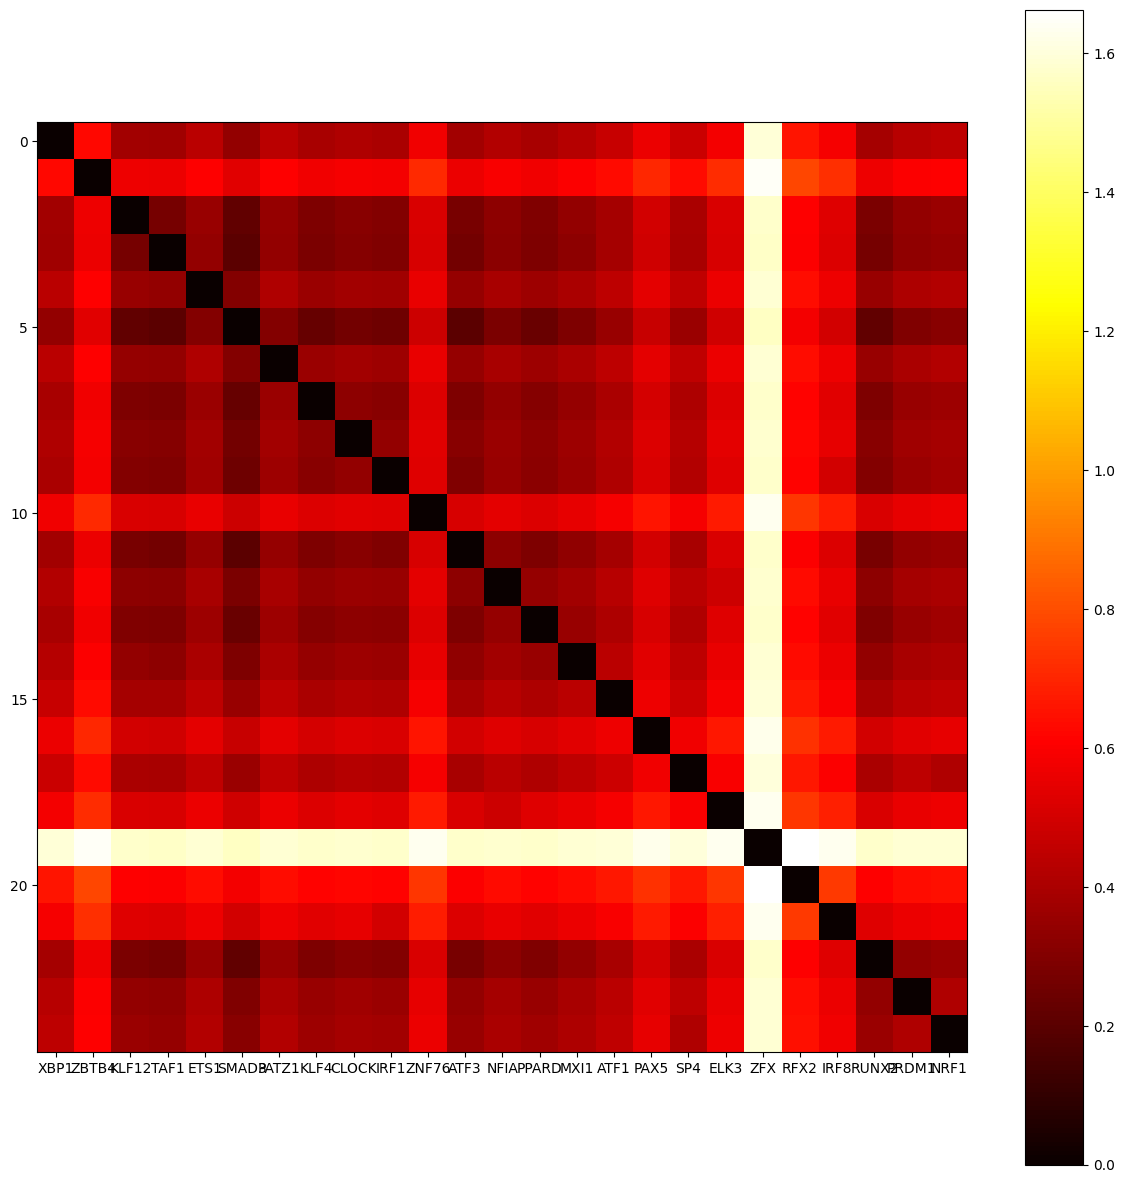

In [395]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(S, cmap='hot')
plt.xticks(range(len(TFList_in_Data)), TFList_in_Data)
plt.colorbar()
plt.show()


In [396]:
lamb = 0.001
pho = 0.000001#np.sqrt(NumSample)
h = 1
Group = [range(NumFeature)]#GroupInd#

k = 6
h = 1
      
# parameters that can be changed
options = {'maxIter': 400, 'verbose': 1}

K_Range = range(3,10)
MSE_Our = np.zeros(len(K_Range))
for i in range(len(K_Range)):
    k = K_Range[i]
    
    uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)
    
    uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
    #print(zout_ppi.flatten())
    SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)

    TF_Select = list()
    for idt in SelectID:
        TF_Select.append(TFList_in_Data[idt])
    print(TF_Select)


    MSE_Our[i] = Out_of_Sample_MSE(CD4_scRNA_DN_magic_ad, TG, TF_Select, SampleID_train, SampleID_outofsample)
    print(k, MSE_Our[i])


Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3']
3 0.016114080333723753
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12']
4 0.015964048243801078
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12', 'RUNX2']
5 0.0156450244807531
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12', 'RUNX2', 'KLF4']
6 0.013297656138376164
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12', 'RUNX2', 'KLF4', 'PPARD']
7 0.01409847609245926
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12', 'RUNX2', 'KLF4', 'PPARD', 'IRF1']
8 0.013103949814875473
Directional Derivative below optTol
['SMAD3', 'TAF1', 'ATF3', 'KLF12', 'RUNX2', 'KLF4', 'PPARD', 'IRF1', 'CLOCK']
9 0.013082452671043545


In [397]:
TF_Select_scenic = ['CREB5', 'BCL11B', 'KLF4', 'SPI1', 'FOS']
print(TF_Select_scenic)
MSE_scenic = Out_of_Sample_MSE(CD4_scRNA_DN_magic_ad, TG, TF_Select_scenic, SampleID_train, SampleID_outofsample)
print(MSE_scenic)

['CREB5', 'BCL11B', 'KLF4', 'SPI1', 'FOS']
0.013756209006467365


[3.         6.01302324 9.        ]


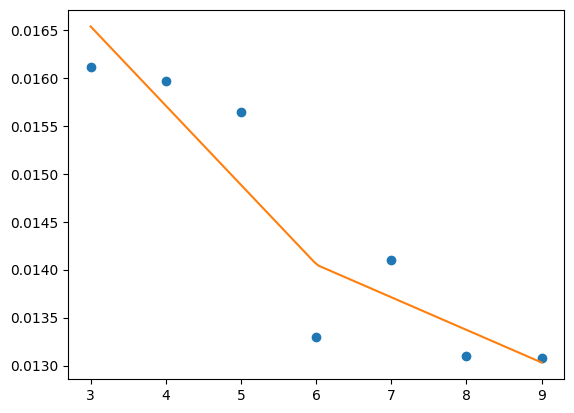

In [398]:
import pwlf

my_pwlf = pwlf.PiecewiseLinFit(K_Range, MSE_Our)
breaks = my_pwlf.fit(2)
print(breaks)

x_hat = np.linspace(K_Range[0], K_Range[-1], 100)
y_hat = my_pwlf.predict(x_hat)

plt.figure()
plt.plot(K_Range, MSE_Our, 'o')
plt.plot(x_hat, y_hat, '-')
plt.show()

In [379]:
from scipy import optimize
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x <= x0], [lambda x:k1*x + y0+k1*x0, lambda x:k1*x0 + y0-k1*x0])

p , e = optimize.curve_fit(piecewise_linear, K_Range, MSE_Our)
print(p)

[1. 1. 1. 1.]


/var/folders/x5/p97rd26d6y719tstlhqtn9zr0000gr/T/ipykernel_75734/1478162136.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  p , e = optimize.curve_fit(piecewise_linear, K_Range, MSE_Our)


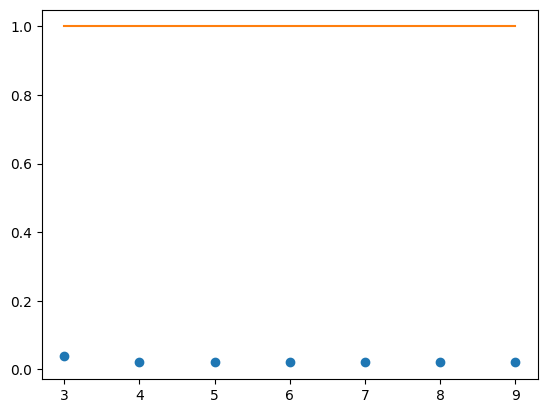

In [380]:
xd = np.linspace(3, 9, 100)
plt.plot(K_Range, MSE_Our, "o")
plt.plot(xd, piecewise_linear(xd, *p))

In [359]:
TF_Select = list()
for idt in SelectID:
    TF_Select.append(TFList_in_Data[idt])
print(TF_Select)
#print(SelectID_Best)
TF_Group = Show_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, TF_Select)

TF_Select = TF_Select_scenic
print(TF_Select)
TF_Group = Show_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, TF_Select)

['ESR1', 'MYC', 'HIF1A', 'SMAD3', 'JUN', 'ESR2', 'RXRA', 'FOS', 'BCL6']
0 [] 0
1 [] 0
2 [] 0
3 [] 1
4 ['RXRA'] 0
5 [] 0
6 ['RXRA'] 0
7 ['RXRA', 'HIF1A', 'SMAD3'] 0
8 ['SMAD3'] 0
9 [] 0
10 [] 0
11 ['RXRA', 'BCL6'] 0
12 ['MYC'] 0
13 ['BCL6'] 0
14 ['RXRA', 'MYC', 'ESR1'] 0
15 ['RXRA'] 0
16 [] 0
17 [] 0
18 ['RXRA'] 0
19 ['ESR1'] 0
20 [] 1
21 [] 0
22 ['RXRA'] 0
23 ['JUN', 'FOS', 'ESR2', 'ESR1'] 0
24 [] 0
25 ['MYC', 'SMAD3'] 0
26 ['RXRA', 'ESR2', 'SMAD3'] 0
27 ['ESR1'] 0
['CREB5', 'BCL11B', 'KLF4', 'SPI1', 'FOS']
0 ['KLF4'] 0
1 ['KLF4'] 0
2 ['KLF4'] 0
3 [] 1
4 [] 0
5 ['SPI1'] 0
6 [] 0
7 [] 0
8 ['KLF4'] 0
9 ['SPI1'] 0
10 [] 0
11 ['SPI1', 'KLF4', 'CREB5'] 0
12 [] 0
13 ['KLF4'] 0
14 ['KLF4'] 0
15 [] 0
16 ['KLF4'] 0
17 ['KLF4'] 0
18 ['KLF4'] 0
19 [] 0
20 [] 1
21 [] 0
22 ['KLF4'] 0
23 ['FOS'] 0
24 ['KLF4'] 0
25 ['KLF4'] 0
26 ['KLF4'] 0
27 ['KLF4'] 0


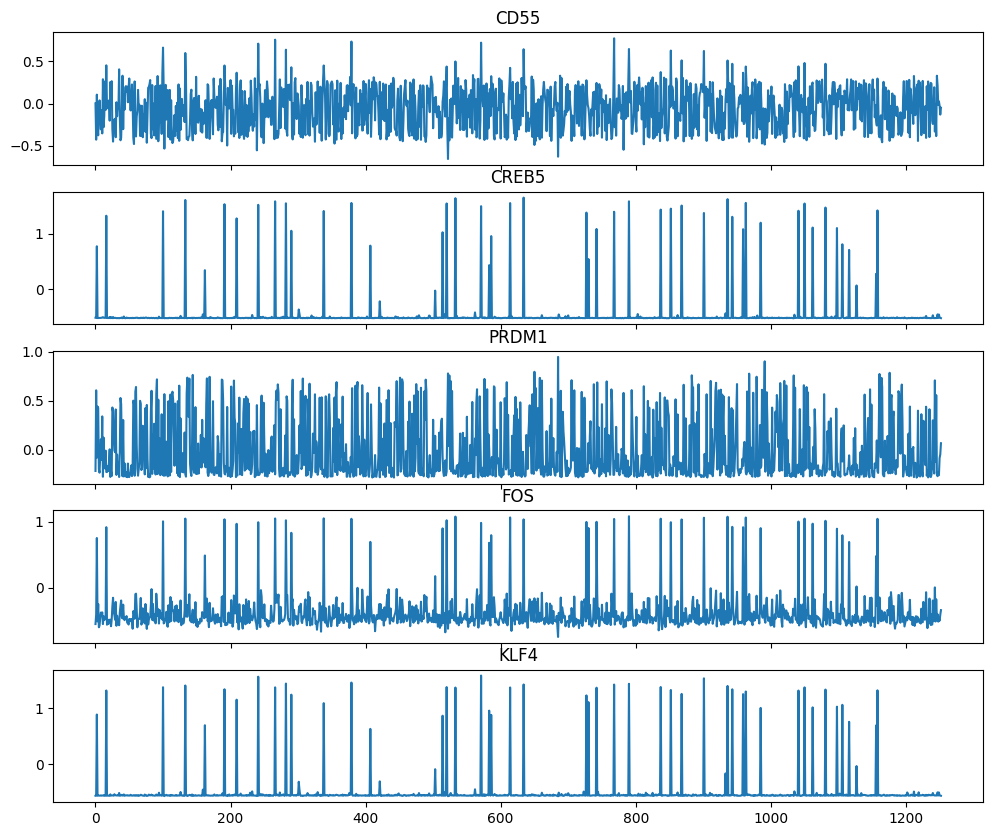

In [330]:
GS = GL  + (TF_Select)
yt = CD4_scRNA_DN_magic_ad[:,GS].X

fig, ax = plt.subplots(nrows=len(GS), ncols=1, sharex=True, figsize=(12, 10))
for i in range(len(GS)):
    ax[i].plot(yt[:,i])
    ax[i].set_title(GS[i])


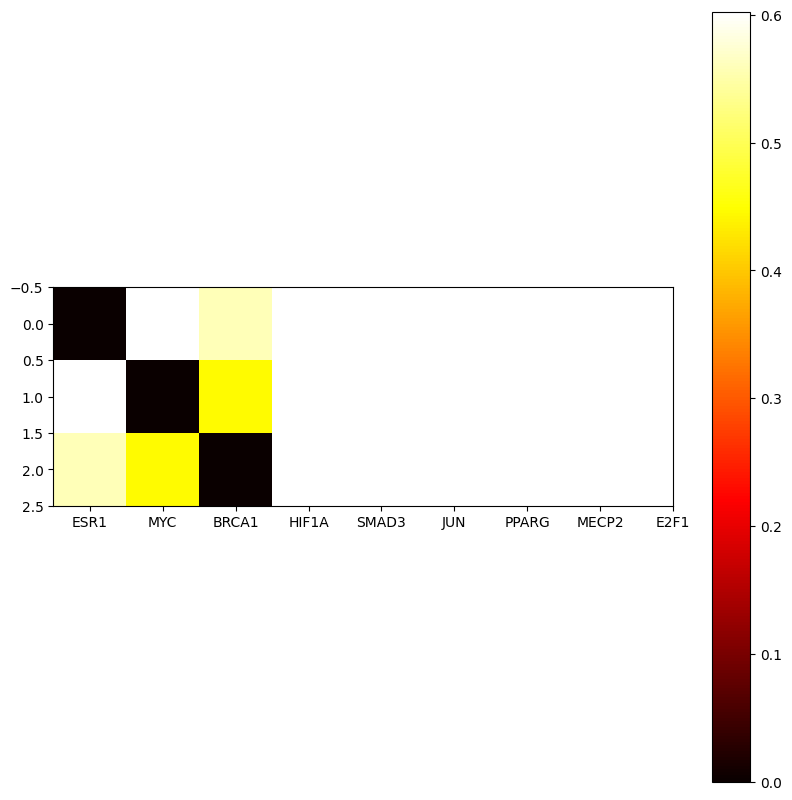

In [238]:
St =  Short_Path_DSD_Matrix(G_PPI_BioGrid, ['IRF8', 'MEF2C', 'HES1'])#Short_Path_Matrix(G_PPI_BioGrid, TFList_in_Data)


fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(St, cmap='hot')
plt.xticks(range(len(TF_Select)), TF_Select)
plt.colorbar()
plt.show()

In [ ]:
lamb = 0.0
pho = 0.1#np.sqrt(NumSample)
h = 1
Group = [range(NumFeature)]#GroupInd#

uSimplex = np.ones((NumFeature, 1)) * (1 / NumFeature)
print(uSimplex.shape)

S = Short_Path_Matrix(G_PPI_BioGrid, TFList_in_Data)
ShortPath = ShorestPath_GivenTFs(G_PPI_BioGrid, TFList_in_Data, "TestShortPath.txt")
print(S.shape)

NumItr = 10
k_range = range(3,10)
#k = 6
h_range = range(1,2)
SelectID_Best = ()
LSE_best = 10000
for k in k_range:
    for h in h_range:
        LSE_Tmp = np.zeros(NumItr)
        for i in range(NumItr):
            X, y, X_outsample, y_outsample = Split_Sample(Xt, yt, 0.9)
            
            # parameters that can be changed
            options = {'maxIter': 400, 'verbose': 1}
    
            uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)
    
            uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
            #print(zout_ppi.flatten())
            SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)
        
            ut = np.zeros((NumFeature,1))
            ut[SelectID,0] = 1.0

            ObjF, _  = L0GL_PPI_Obj(ut, X, y, S, pho, lamb)
            #print("Obj:", ObjF)
            #print("Short Dis;", ut.T@S@ut)


            XSelect = X[:,SelectID]
            w_est = np.linalg.pinv(XSelect.T @ XSelect + pho*np.eye(len(SelectID))) @ XSelect.T @ y
            #print(TF_Select)
            #print(np.abs(w_est.flatten()))

            X_outsample_select = X_outsample[:, SelectID]
            LSE_Tmp[i] = np.linalg.norm(y_outsample - X_outsample_select @ w_est)
        LSE = np.mean(LSE_Tmp)    
        print('k=',k, 'h=', h,"Out-of-sample LSE:", LSE)
    
        if LSE < LSE_best:
            LSE_best = LSE
            SelectID_Best = SelectID
    
    

In [ ]:
TF_Select = list()
for idt in SelectID_Best:
    TF_Select.append(TFList_in_Data[idt])
print(TF_Select)
print(SelectID_Best)

TF_Group = Show_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, TF_Select)

In [ ]:
TF_Select = list()
for idt in SelectID_Best:
    TF_Select.append(TFList_in_Data[idt])
print(TF_Select)
print(SelectID_Best)

TF_Group = Show_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, TF_Select)

In [ ]:
uout, obj, _ = minConF_PQN(funObj_PPI, uSimplex, funProj_GL_LB, options)

In [ ]:
uout_ppi, zout_ppi = ProjCSimplexGL_Gurobi_LB_v2(uout, k, Group, h)
print(zout_ppi.flatten())
SelectID = Extract_Solution(uout_ppi, zout_ppi, Group, k, h)


TF_Select = list()
for idt in SelectID:
    TF_Select.append(TFList_in_Data[idt])
print(TF_Select)
print(SelectID)

In [ ]:
TF_Group = Show_TFs_in_Data(TG, pbmc_3k_scATAC_Gene_Enhancer_CD4_psum, ColSelect, Map_Gene_GTOpenR, TF_Select)

In [ ]:
ut = np.zeros((NumFeature,1))
ut[SelectID,0] = 1.0

ObjF, _  = L0GL_PPI_Obj(ut, X, y, S, pho, lamb)
print("Obj:", ObjF)
print("Short Dis;", ut.T@S@ut)


XSelect = X[:,SelectID]
w_est = np.linalg.pinv(XSelect.T @ XSelect) @ XSelect.T @ y
print(TF_Select)
print(np.abs(w_est.flatten()))

X_outsample_select = X_outsample[:, SelectID]
LSE = np.linalg.norm(y_outsample - X_outsample_select @ w_est)
print("Out-of-sample LSE:", LSE)

In [ ]:
plt.plot(y_outsample)
plt.plot(X_outsample_select @ w_est)

In [ ]:
uout_ppi = ProjCSimplexGL_Gurobi_LB(uout, k, Group, h)

In [ ]:
np.argsort(-zout_ppi.flatten())

In [ ]:
zout_ppi.flatten()

In [ ]:
Ind = np.argsort(-uout_ppi.flatten())[0:30]
print(Ind)
TFRes = list()
for idt in Ind:
    #print(TFList_in_Data[idt])
    TFRes.append(TFList_in_Data[idt])
print(TFRes)

In [ ]:
TFList_Raw = Tmp_Input['TF_Matching_p-value_1e-05'].tolist()
Chr_Position_Raw = Tmp_Input['chr_position'].tolist()
count = 0
for tfl, chp in zip(TFList_Raw, Chr_Position_Raw):
    if chp in Map_Gene_GTOpenR[GL[0]]:
        hit = 1
    else:
        hit = 0
    olp = list(set(tfl) & set(TFRes))
    print(count, olp, hit)
    count = count + 1

In [ ]:
uout.T @ S @ uout

In [ ]:
ShortPath = ShorestPath_GivenTFs(G_PPI_BioGrid, TFRes, "TestShortPath_Result.txt")
print(ShortPath)

# Tmp

In [ ]:
Tmp_Input

In [ ]:
Tmp_GT

In [ ]:
Tmp_Input

In [ ]:
tsp

In [ ]:
TFList_Raw = Tmp['TFs_binding'].tolist()
Hit_Raw = Tmp['Hit'].tolist()
for tfl,hit in zip(TFList_Raw, Hit_Raw):
    olp = list(set(tfl) & set(Gene_scRNA))
    print(olp, hit)

In [ ]:
Tmp['baitNameList'][0]

In [ ]:
for gt in Gene_Validate:
    GL = [gt]
    #print(GL)
    Tmp = CD4_scATAC_Gene_TF_Enhancer_PCHiC_Trim[CD4_scATAC_Gene_TF_Enhancer_PCHiC_Trim['Genes_within_250k'].apply(lambda x: any(gene in x for gene in GL))].reset_index()

    TF_Candiates =  list(set(list(itertools.chain.from_iterable(Tmp['TFs_binding'].tolist()))))
    #print(TF_Candiates)

    TF_In_Data = list(set(Gene_scRNA) & set(TF_Candiates))
    #print(TF_In_Data)
    
    Num_GT = Tmp[~Tmp['baitNameList'].isnull()]['baitNameList'].apply(lambda x: any(gene in x for gene in GL)).sum()
    
    print(gt, "Total_TF / TF_in_Data = ", len(TF_Candiates), "/", len(TF_In_Data), "GT number:", Num_GT)
    

In [ ]:
CD4_scATAC_Gene_TF_Enhancer[['chr', 'start', 'end']] = CD4_scATAC_Gene_TF_Enhancer['chr_position'].str.split('_', expand=True)

In [ ]:
CD4_scATAC_Gene_TF_Enhancer

In [ ]:

GL = [Gene_Validate[0]]
    #print(tg)
Tmp = CD4_scATAC_Gene_TF_Enhancer[CD4_scATAC_Gene_TF_Enhancer['output_grch38_col4'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
TG_TFList = list(set(list(itertools.chain.from_iterable(Tmp['output_fimo_col4'].tolist()))))
    #print("TFs for the target is", len(TG_TFList))

TG_TGList_InData = list(set(TG_TFList) & set(Gene_scRNA))
    #print("TFs for the target in the data is", len(TG_TGList_InData))


In [ ]:
Tmp

In [ ]:
GeneCount = 0
TruthRegion = 0
Gene_with_GroundTruth = list()
True_OpenRegin_List = list()
for tg in Gene_Validate:
    GL = [tg]
    Tmp = CD4_scATAC_Gene_TF_Enhancer[CD4_scATAC_Gene_TF_Enhancer['output_grch38_col4'].apply(lambda x: any(gene in x for gene in GL))].reset_index()
    TG_TFList = list(set(list(itertools.chain.from_iterable(Tmp['output_fimo_col4'].tolist()))))
    #print("TFs for the target is", len(TG_TFList))

    TG_TGList_InData = list(set(TG_TFList) & set(Gene_scRNA))
    #print("TFs for the target in the data is", len(TG_TGList_InData))

    Tmp = Tmp[Tmp['sum']>=1]
    #print(Tmp)

    CD4_Target = CD4_PCHiC[CD4_PCHiC['baitNameList'].apply(lambda lst: tg in lst) ]

    Start_val = Tmp['start'].values.astype(int)
    End_val = Tmp['end'].values.astype(int)

    oeStart_val = CD4_Target['oeStart'].values
    oeEnd_val = CD4_Target['oeEnd'].values

    start_mask = np.logical_and(
        Start_val[:, np.newaxis] >= oeStart_val-500,
        Start_val[:, np.newaxis] <= oeEnd_val+500
    )

    end_mask = np.logical_and(
        End_val[:, np.newaxis] >= oeStart_val-500,
        End_val[:, np.newaxis] <= oeEnd_val+500
    )


    HitList=np.array(np.logical_or(start_mask, end_mask).sum(axis=1))
    #print(HitList)
    Ind = np.where(HitList)[0]
    #print(Ind)
    #print(Tmp['chr_position'])
    #print(Tmp['chr_position'][Ind].values)
    OP_Hit_List = Tmp['chr_position'][Ind].values
    #print(OP_Hit_List)
    
    Overlap_regions = np.logical_or(start_mask, end_mask).any(axis=1).sum()
    if Overlap_regions > 0:
        GeneCount = GeneCount + 1
        TruthRegion = TruthRegion + Overlap_regions
        Gene_with_GroundTruth.append(tg)
        #print(tg)
        #print("TFs for the target is", len(TG_TFList))
        #print("TFs for the target in the data is", len(TG_TGList_InData))
        print(tg, "open reigions(", Tmp.shape[0], ")overlaps with", Overlap_regions, "within the PCHiC", CD4_Target.shape[0], "TF_Raw/TF_Exp=", len(TG_TFList), "/", len(TG_TGList_InData))
        True_OpenRegin_List.extend(OP_Hit_List)
        #print(OP_Hit_List[0])
        

In [ ]:
print("Gene:", len(Gene_with_GroundTruth), "Links", TruthRegion)

In [ ]:
len(set(True_OpenRegin_List))

In [ ]:
CD4_scATAC_Gene_TF_Enhancer['Hit_PCHiC'] = 0

In [ ]:
CD4_scATAC_Gene_TF_Enhancer['Hit_PCHiC'] = CD4_scATAC_Gene_TF_Enhancer['chr_position'].apply(lambda x: 1 if x in True_OpenRegin_List else 0)

In [ ]:
CD4_scATAC_Gene_TF_Enhancer['chr_position'].apply(lambda chrp: chrp in True_OpenRegin_List)['Hit_PCHiC'] = 1

In [ ]:
CD4_scATAC_Gene_TF_Enhancer

In [ ]:
CD4_scATAC_Gene_TF_Enhancer[CD4_scATAC_Gene_TF_Enhancer['chr_position'] == True_OpenRegin_List[0]]

In [ ]:
Tmp = CD4_scATAC_Gene_TF_Enhancer[CD4_scATAC_Gene_TF_Enhancer['output_grch38_col4'].apply(lambda x: any(gene in x for gene in ['MAPKAPK2']))].reset_index()


In [ ]:
Tmp

In [ ]:
Tmp_TFs = Tmp['output_fimo_col4'].tolist()
for tfl in Tmp_TFs:
    Int = list(set(TG_TGList_InData) & set(tfl))
    print(sorted(Int))

In [ ]:
sp = nx.shortest_path_length(G_PPI_BioGrid, 'PAX5', 'SP2')
print(sp)
Path = nx.shortest_path(G_PPI_BioGrid, source='PAX5', target='SP2')
print(Path)

In [ ]:
Tmp

In [ ]:
Tmp[['chr', 'start', 'end']] = Tmp['chr_position'].str.split('_', expand=True)

In [ ]:
Tmp

In [ ]:
CD4_Target = CD4_PCHiC[CD4_PCHiC['baitNameList'].apply(lambda lst: TargetG in lst) ]

In [ ]:
Start_val = Tmp['start'].values.astype(int)
End_val = Tmp['end'].values.astype(int)

oeStart_val = CD4_Target['oeStart'].values
oeEnd_val = CD4_Target['oeEnd'].values

In [ ]:
start_mask = np.logical_and(
        Start_val[:, np.newaxis] >= oeStart_val,
        Start_val[:, np.newaxis] <= oeEnd_val
    )

end_mask = np.logical_and(
        End_val[:, np.newaxis] >= oeStart_val,
        End_val[:, np.newaxis] <= oeEnd_val
    )

Overlap_regions = np.logical_or(start_mask, end_mask).any(axis=1).sum()

In [ ]:
Overlap_regions

In [ ]:
CD4_Target

In [ ]:
int(gene_tss[gene_tss['genes'] == TargetG]['tss_corrected'].values[0])+250000, int(gene_tss[gene_tss['genes'] == TargetG]['tss_corrected'].values[0])-250000

In [ ]:
print(Tmp['output_fimo_col4'].tolist())

In [ ]:
GL